# Multi-Headed Simplex attention experiments on `SimplePeriodicDataset` with overlapping source and target 

In [14]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import sys
import os
sys.path.append(os.path.abspath('../../'))  #Couldn't figure out how to get src in my path so i fixed it like this

from src.Transformer.DecoderOnly import PointSimplexDecoderOnlyTransformer
from src.Transformer.DistanceMetrics import euclidean, cosine, manhattan, infinity_norm


import src.Datasets.SyntheticDataset as SD
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

ES = EarlyStopping(patience=45, delta=1)

In [15]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# meta data to store images
FOLDER = "simplex_transformer"
KERNEL_NAME = "simplex"

# transformer configs
n_layers = 1                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions
norm_first = True                       # LayerNorm order (keep consistent)
conv_out_dim = 32                            # Output dimension for convolutional part in Simplex block (example value)
kernel_size = 5                              # Kernel size for convolutional part in Simplex block (example value)

# Experiment parameters, these will be changed in the following experiments
n_heads=1                                    # Number of Heads
distance_metric = euclidean                  # Distance metric in custom simplex attention


# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs

In [16]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=False, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

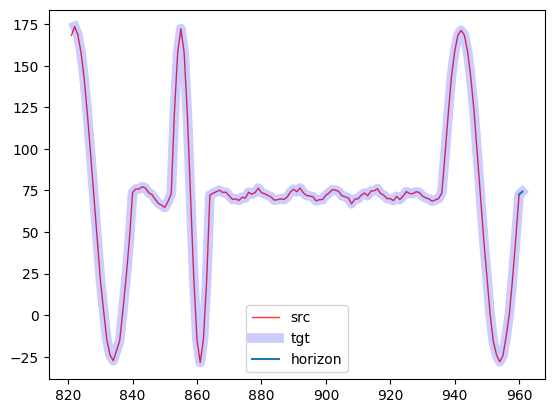

In [17]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

## Experiment 1: One-step and N-step prediction using *one head* and the *euclidean* distance function.

### Training setup

In [18]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = euclidean                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [19]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2708.3683	val_loss=1472.9117	train_mape_loss=1.7743	val_mape_loss=2.2167	R_p=['0.2724', '0.2627']
epoch=1	train_loss=1476.9720	val_loss=1396.6416	train_mape_loss=2.0724	val_mape_loss=2.1641	R_p=['0.2813', '0.2589']
epoch=2	train_loss=1401.0386	val_loss=1287.7572	train_mape_loss=1.9847	val_mape_loss=2.0382	R_p=['0.2914', '0.2607']
epoch=3	train_loss=1244.1385	val_loss=1062.9797	train_mape_loss=1.7771	val_mape_loss=1.5454	R_p=['0.3049', '0.3205']
epoch=4	train_loss=1062.1622	val_loss=921.3083	train_mape_loss=1.4485	val_mape_loss=1.3107	R_p=['0.2852', '0.2448']
epoch=5	train_loss=957.1976	val_loss=835.9257	train_mape_loss=1.1812	val_mape_loss=1.0898	R_p=['0.2775', '0.2489']
epoch=6	train_loss=878.6863	val_loss=779.9476	train_mape_loss=1.0491	val_mape_loss=0.9610	R_p=['0.2640', '0.2291']
epoch=7	train_loss=822.5045	val_loss=745.3706	train_mape_loss=0.9682	val_mape_loss=0.8859	R_p=['0.2525', '0.2246']
epoch=8	train_loss=798.0426	val_loss=733.0607	train_mape_loss=0.9398	va

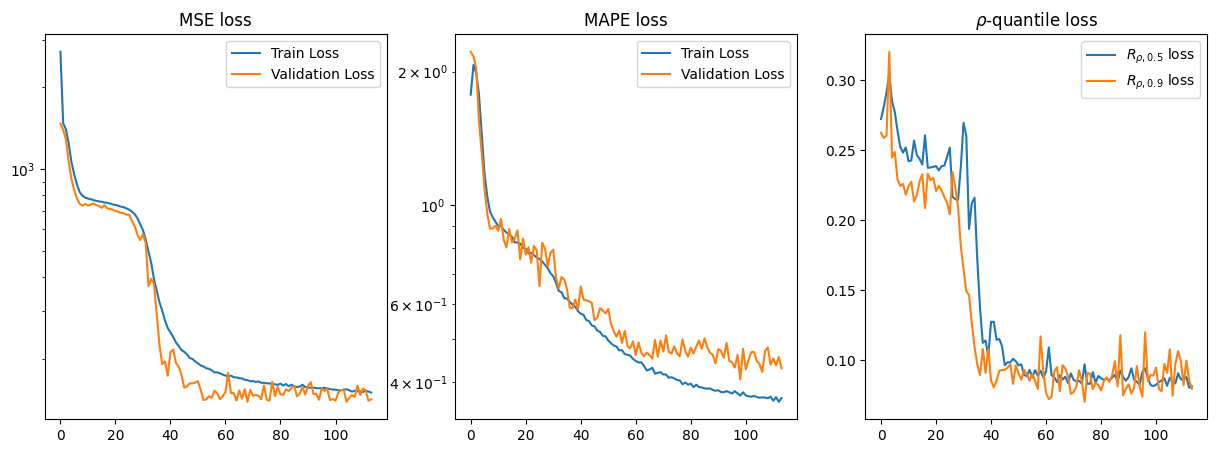

In [20]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [21]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(139.15951013183593,
 0.4045487902164459,
 [0.08087842166423798, 0.07959656417369843])

### N-step prediction

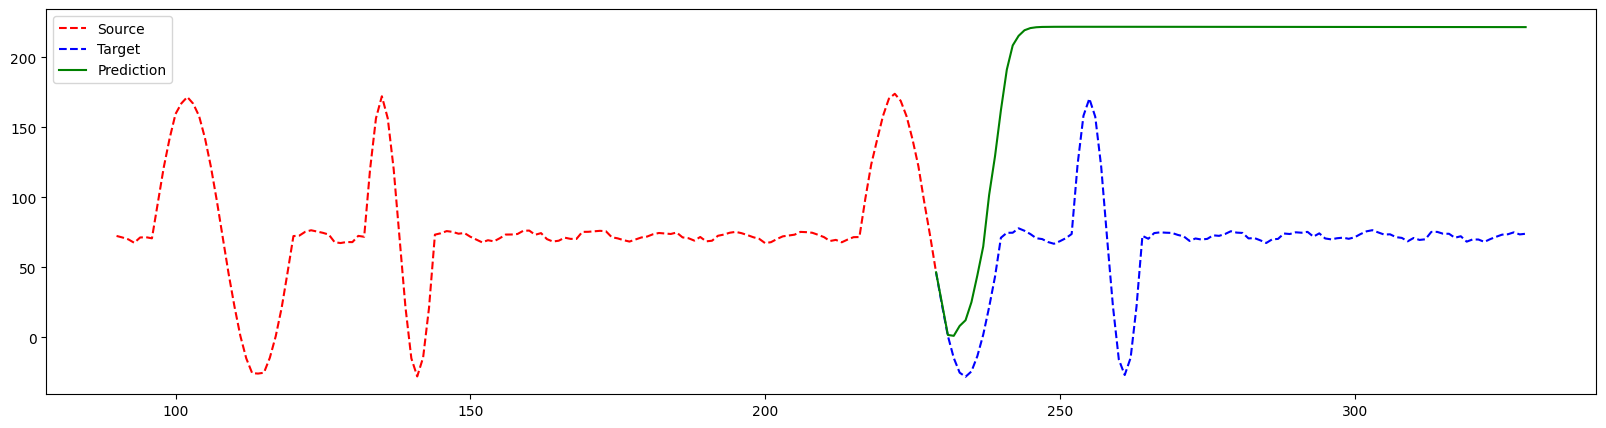

In [22]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

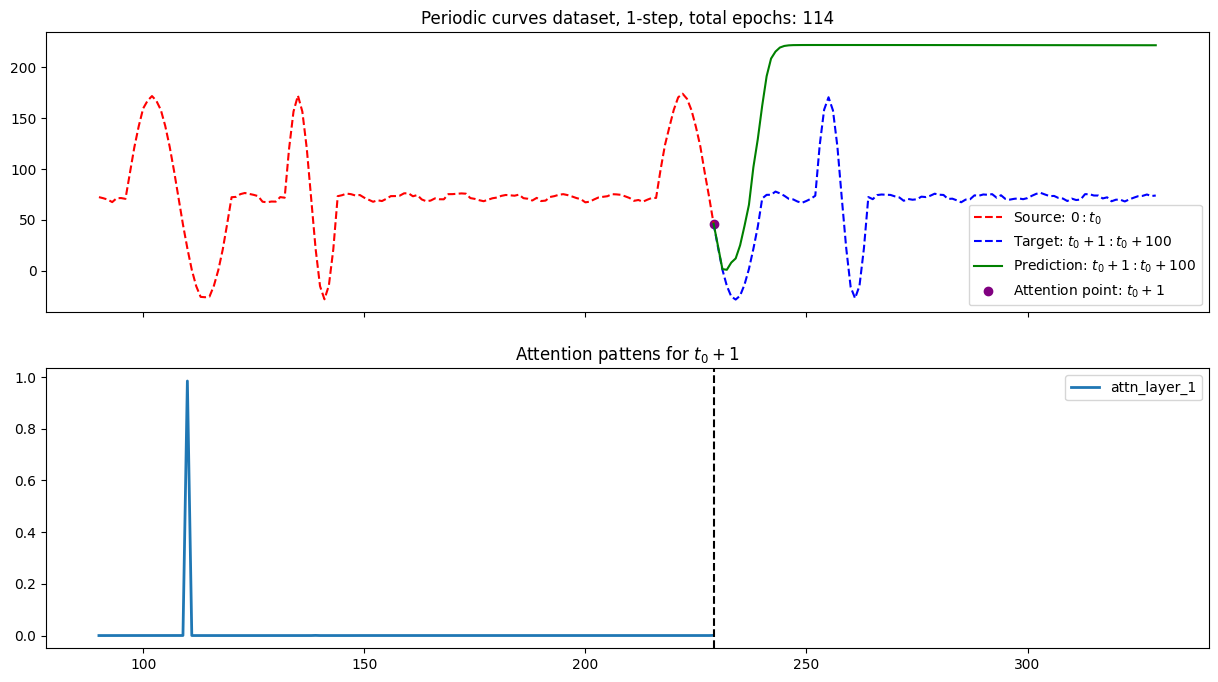

In [23]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

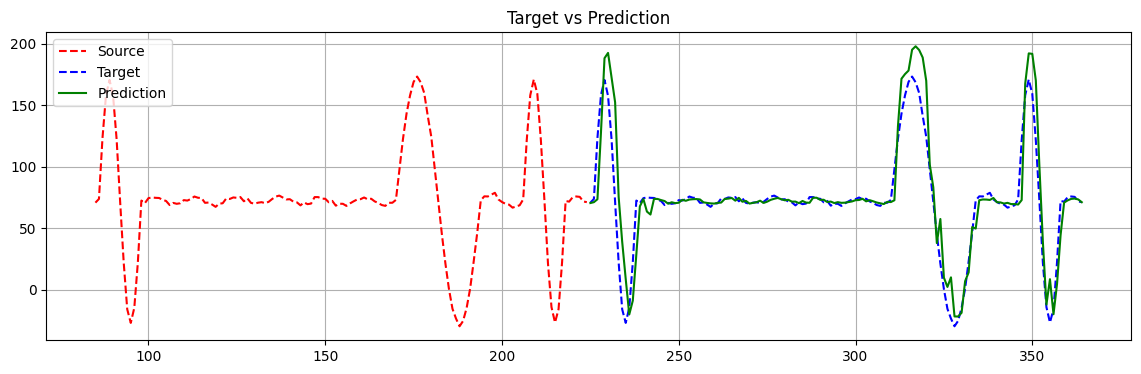

In [24]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 2: One-step and N-step prediction using *two heads* and the *euclidean* distance function.

### Training setup

In [25]:
n_heads = 2                               # Number of heads used in multi headed simplex attention
distance_metric = euclidean                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [26]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2882.2139	val_loss=1482.5111	train_mape_loss=1.7740	val_mape_loss=2.2237	R_p=['0.2731', '0.2634']
epoch=1	train_loss=1487.9808	val_loss=1411.4631	train_mape_loss=2.0810	val_mape_loss=2.1539	R_p=['0.2783', '0.2670']
epoch=2	train_loss=1444.6895	val_loss=1343.8264	train_mape_loss=2.0375	val_mape_loss=2.0763	R_p=['0.2854', '0.2733']
epoch=3	train_loss=1349.5269	val_loss=1190.8714	train_mape_loss=1.9244	val_mape_loss=1.8967	R_p=['0.2941', '0.2710']
epoch=4	train_loss=1151.0174	val_loss=981.3111	train_mape_loss=1.6337	val_mape_loss=1.5793	R_p=['0.2917', '0.2441']
epoch=5	train_loss=976.0684	val_loss=856.9197	train_mape_loss=1.2432	val_mape_loss=1.0234	R_p=['0.2741', '0.2787']
epoch=6	train_loss=903.1906	val_loss=821.2292	train_mape_loss=1.0792	val_mape_loss=1.0303	R_p=['0.2699', '0.2424']
epoch=7	train_loss=850.6270	val_loss=780.3822	train_mape_loss=0.9795	val_mape_loss=0.9032	R_p=['0.2519', '0.2447']
epoch=8	train_loss=809.2755	val_loss=741.7156	train_mape_loss=0.9112	va

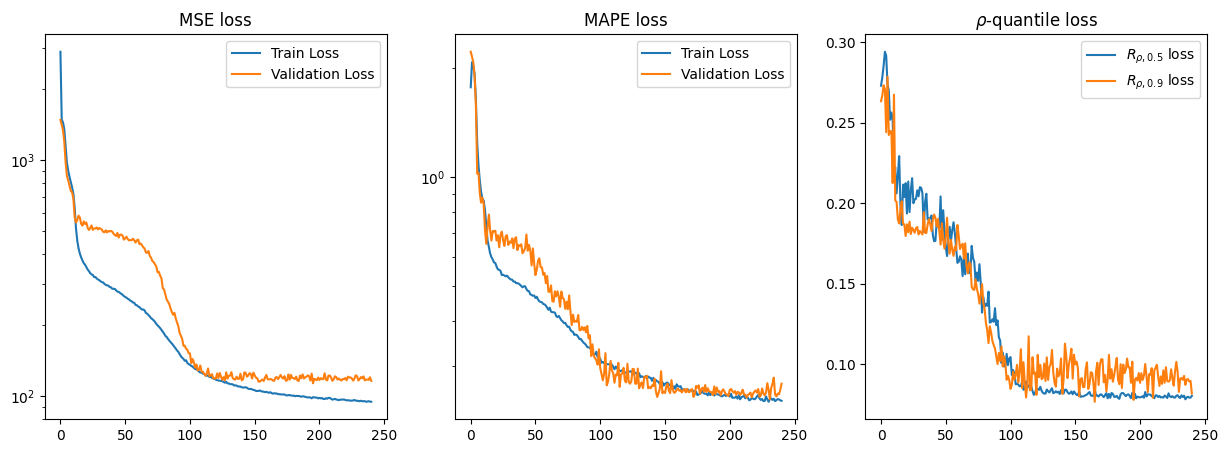

In [27]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [28]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(120.95833142089843,
 0.27861996793746946,
 [0.08161955326795578, 0.0818324163556099])

### N-step prediction

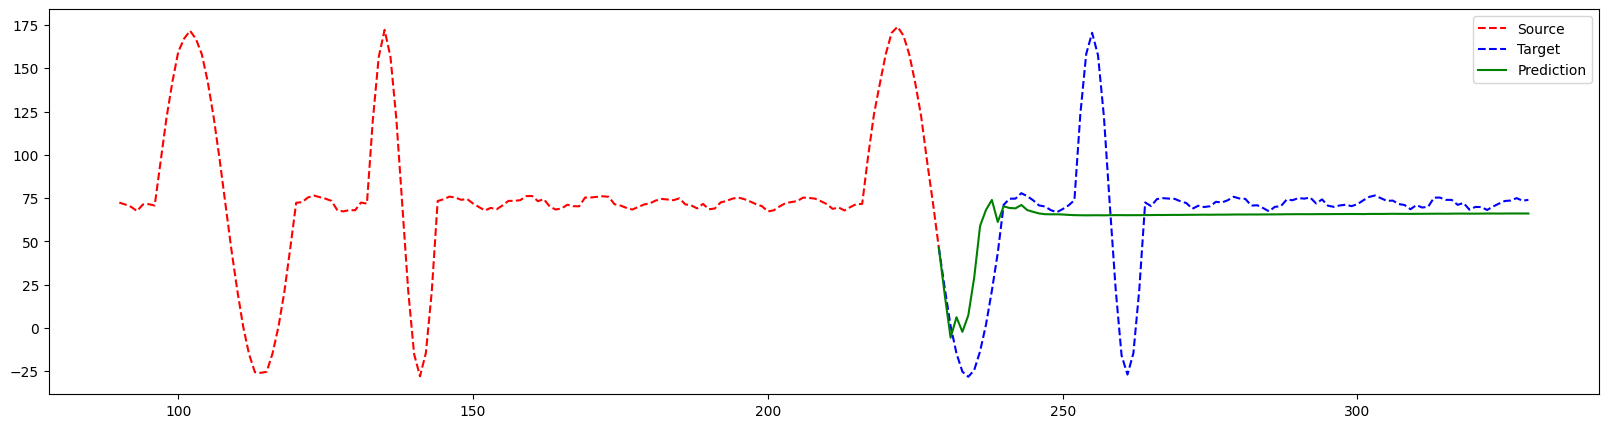

In [29]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

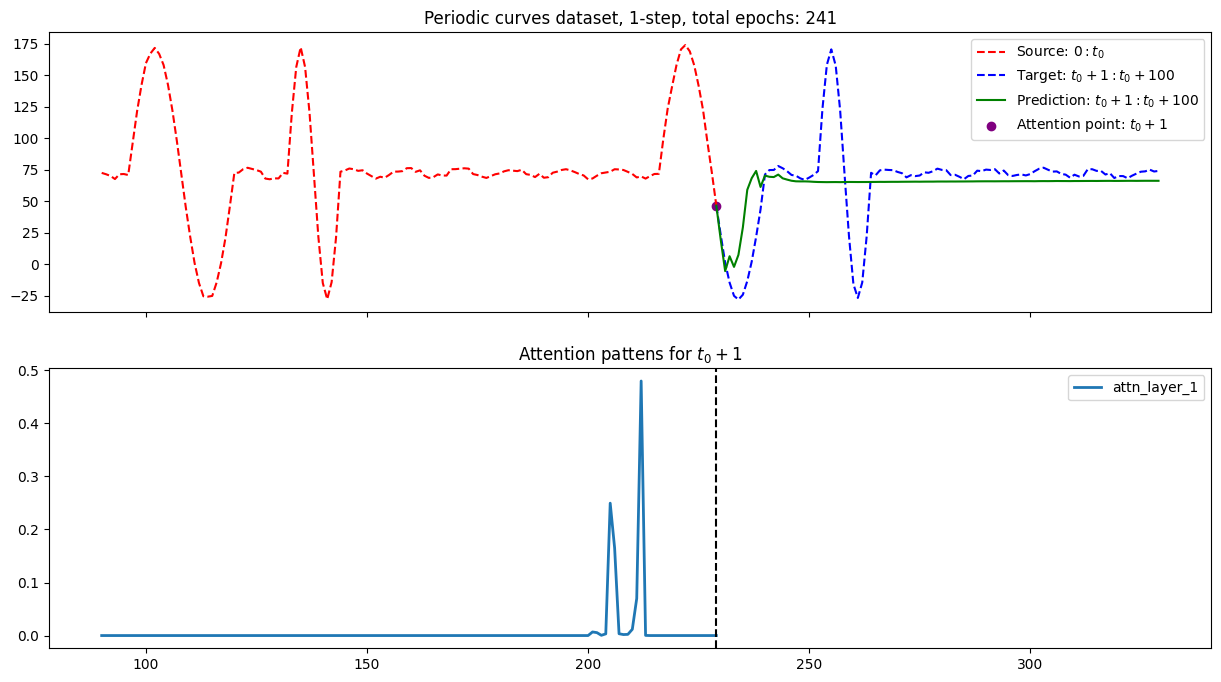

In [30]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

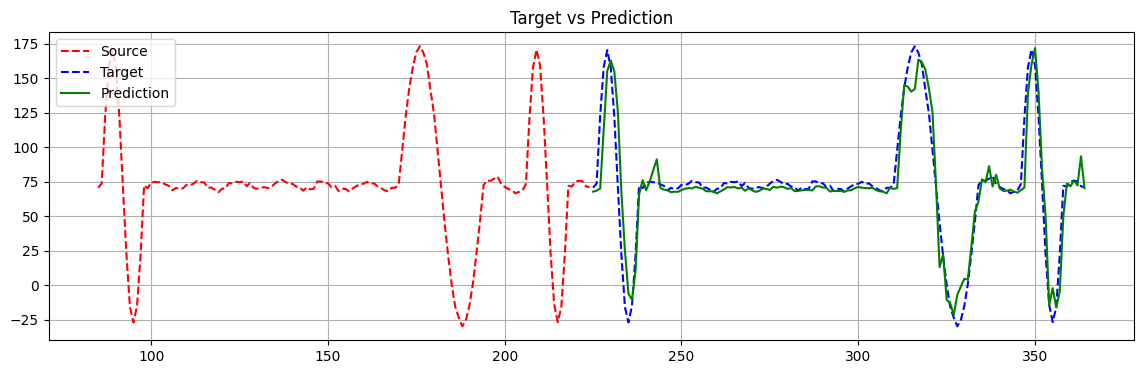

In [31]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 3: One-step and N-step prediction using *four heads* and the *euclidean* distance function.

### Training setup

In [32]:
n_heads = 4                               # Number of heads used in multi headed simplex attention
distance_metric = euclidean                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [33]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2865.3011	val_loss=1472.2481	train_mape_loss=1.7672	val_mape_loss=2.2300	R_p=['0.2747', '0.2594']
epoch=1	train_loss=1487.9209	val_loss=1417.3228	train_mape_loss=2.0833	val_mape_loss=2.1571	R_p=['0.2778', '0.2685']
epoch=2	train_loss=1462.7458	val_loss=1373.2563	train_mape_loss=2.0545	val_mape_loss=2.1319	R_p=['0.2809', '0.2615']
epoch=3	train_loss=1387.4473	val_loss=1281.8419	train_mape_loss=1.9735	val_mape_loss=2.0681	R_p=['0.2900', '0.2460']
epoch=4	train_loss=1270.7707	val_loss=1130.7384	train_mape_loss=1.8208	val_mape_loss=1.8549	R_p=['0.2959', '0.2499']
epoch=5	train_loss=1117.7642	val_loss=954.2786	train_mape_loss=1.5802	val_mape_loss=1.4777	R_p=['0.2985', '0.2699']
epoch=6	train_loss=981.2264	val_loss=887.9844	train_mape_loss=1.2793	val_mape_loss=1.3294	R_p=['0.2930', '0.2301']
epoch=7	train_loss=899.5183	val_loss=812.6076	train_mape_loss=1.0850	val_mape_loss=1.0458	R_p=['0.2722', '0.2334']
epoch=8	train_loss=833.6618	val_loss=759.4454	train_mape_loss=0.9665	

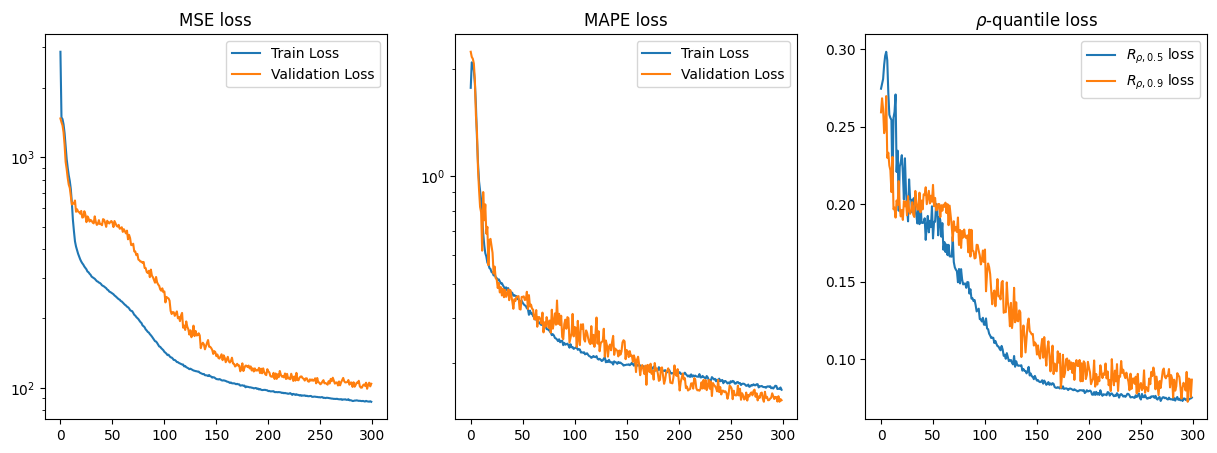

In [34]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [35]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(105.91485614013672,
 0.24149992537498474,
 [0.07604774087667465, 0.08405999839305878])

### N-step prediction

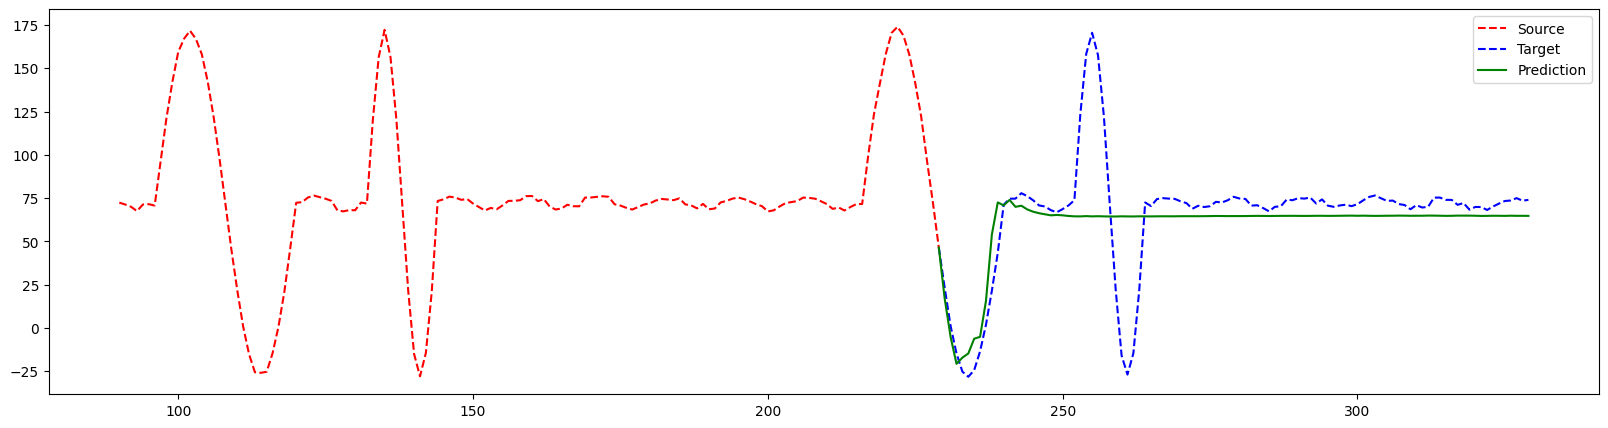

In [36]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

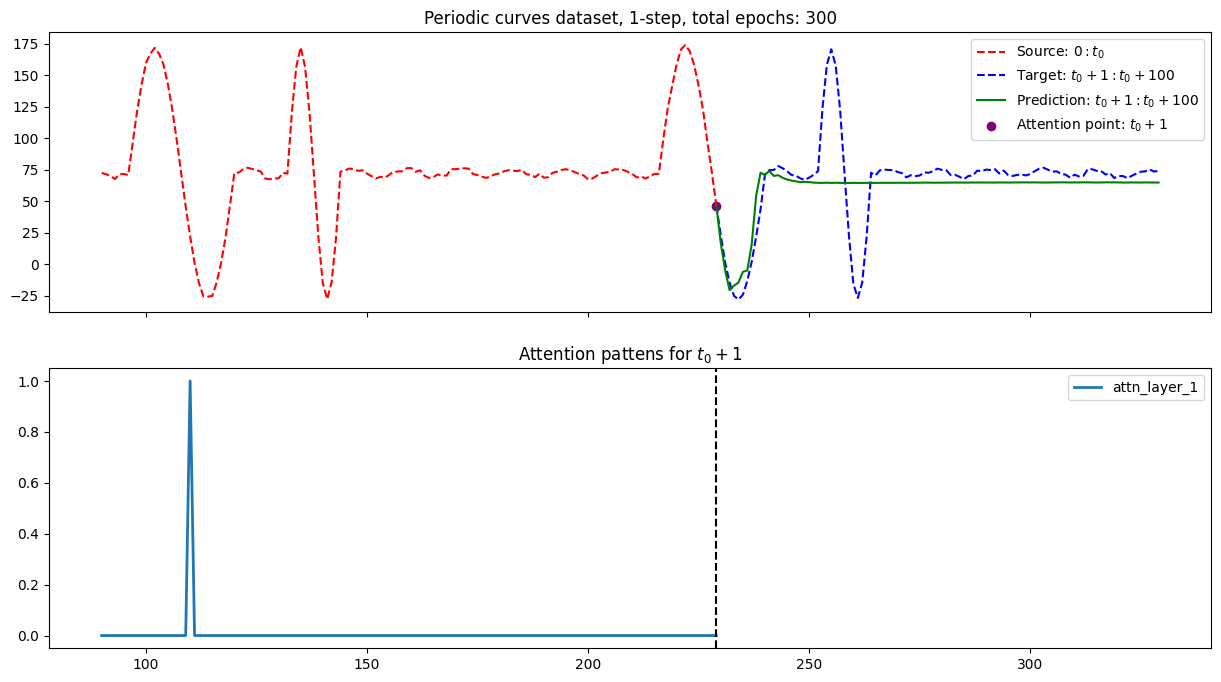

In [37]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

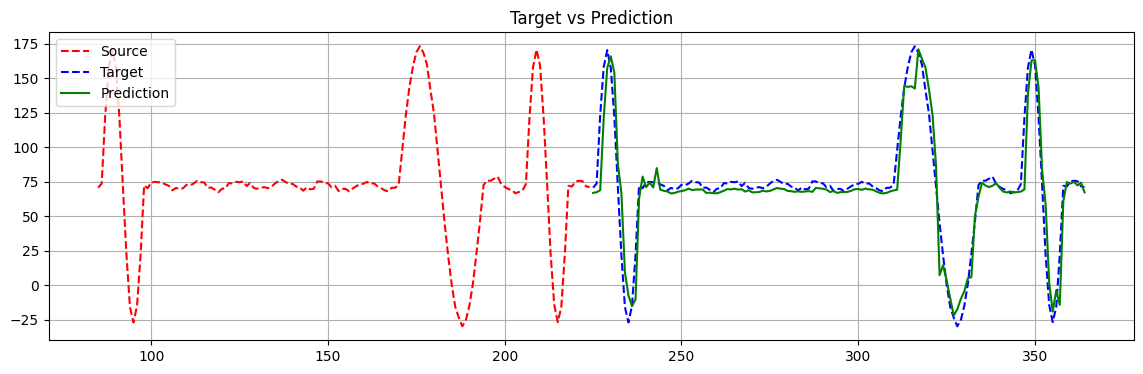

In [38]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 4: One-step and N-step prediction using *eight heads* and the *euclidean* distance function.

### Training setup

In [39]:
n_heads = 8                               # Number of heads used in multi headed simplex attention
distance_metric = euclidean                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [40]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2718.4622	val_loss=1483.3029	train_mape_loss=1.8157	val_mape_loss=2.2258	R_p=['0.2729', '0.2633']
epoch=1	train_loss=1486.3650	val_loss=1412.2007	train_mape_loss=2.0835	val_mape_loss=2.1699	R_p=['0.2784', '0.2612']
epoch=2	train_loss=1467.7052	val_loss=1373.0311	train_mape_loss=2.0595	val_mape_loss=2.1295	R_p=['0.2801', '0.2621']
epoch=3	train_loss=1414.3870	val_loss=1276.8379	train_mape_loss=2.0023	val_mape_loss=2.0286	R_p=['0.2837', '0.2602']
epoch=4	train_loss=1308.7667	val_loss=1121.4650	train_mape_loss=1.8753	val_mape_loss=1.8136	R_p=['0.2892', '0.2664']
epoch=5	train_loss=1176.6260	val_loss=964.2588	train_mape_loss=1.6785	val_mape_loss=1.4427	R_p=['0.2996', '0.2846']
epoch=6	train_loss=1034.9810	val_loss=855.9535	train_mape_loss=1.3946	val_mape_loss=1.0397	R_p=['0.2853', '0.3004']
epoch=7	train_loss=919.6181	val_loss=795.8026	train_mape_loss=1.1544	val_mape_loss=1.0085	R_p=['0.2720', '0.2305']
epoch=8	train_loss=817.4817	val_loss=752.5312	train_mape_loss=0.9909

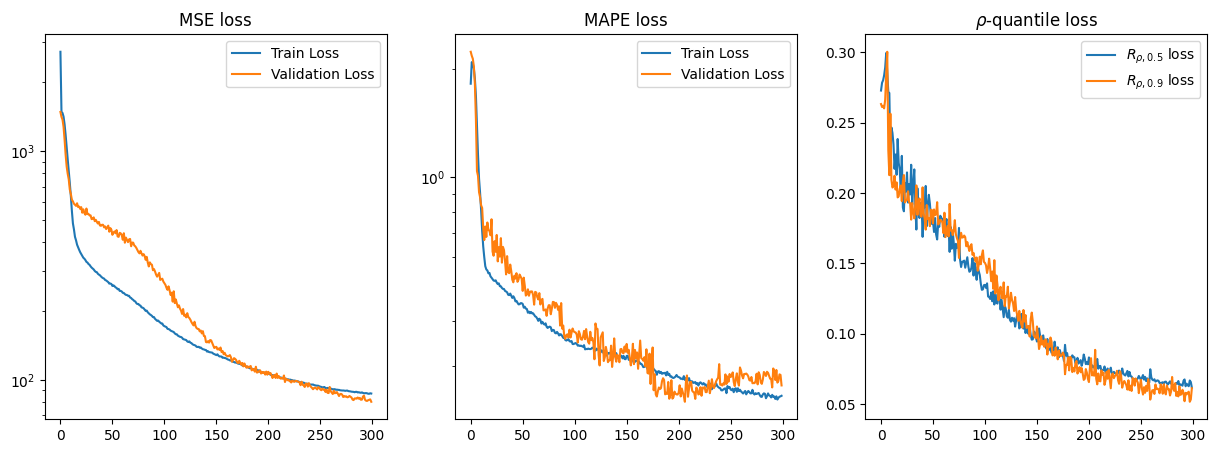

In [41]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [42]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(80.95947436523437,
 0.2676400260925293,
 [0.0634991005063057, 0.058396391570568085])

### N-step prediction

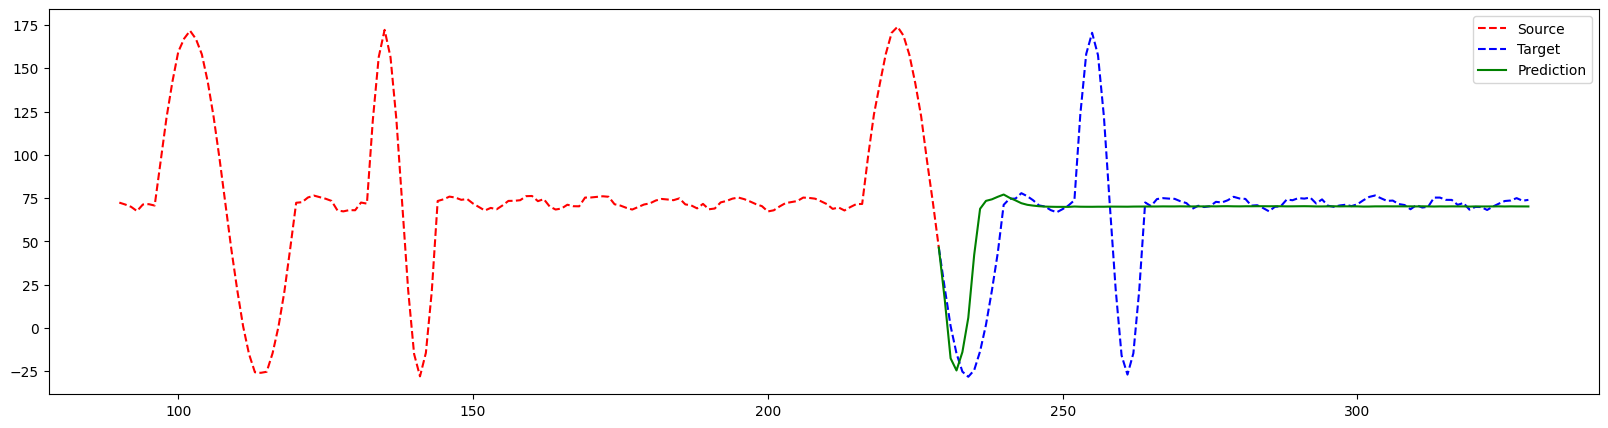

In [43]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

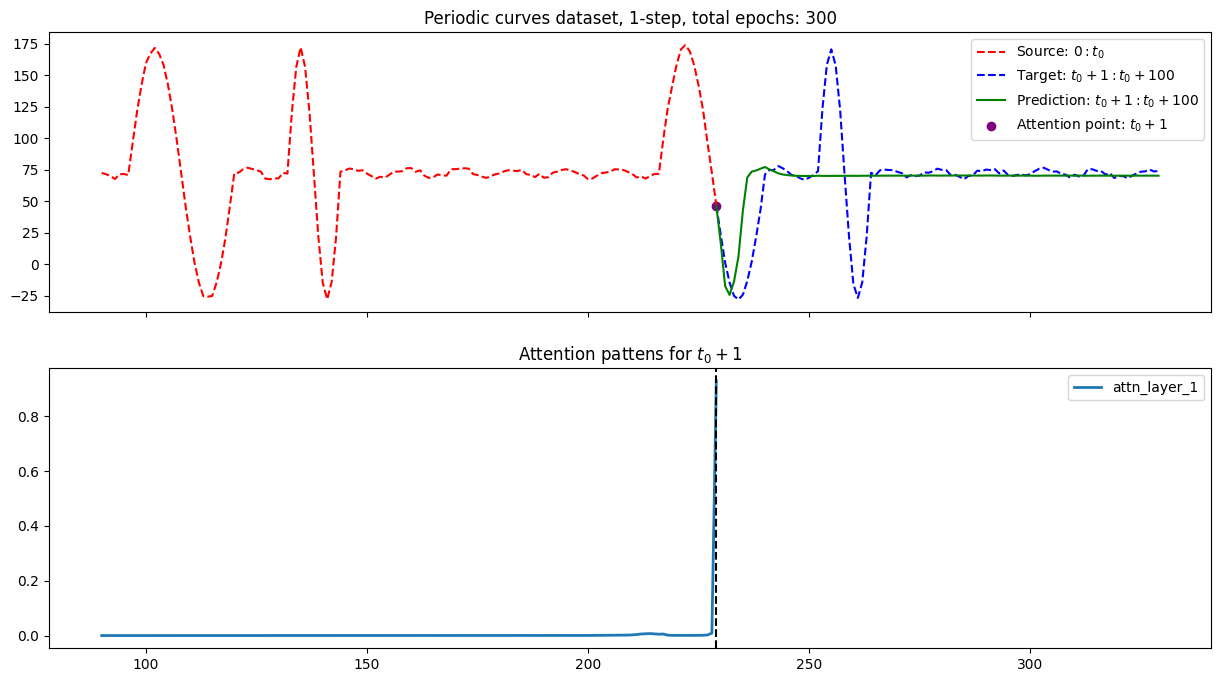

In [44]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

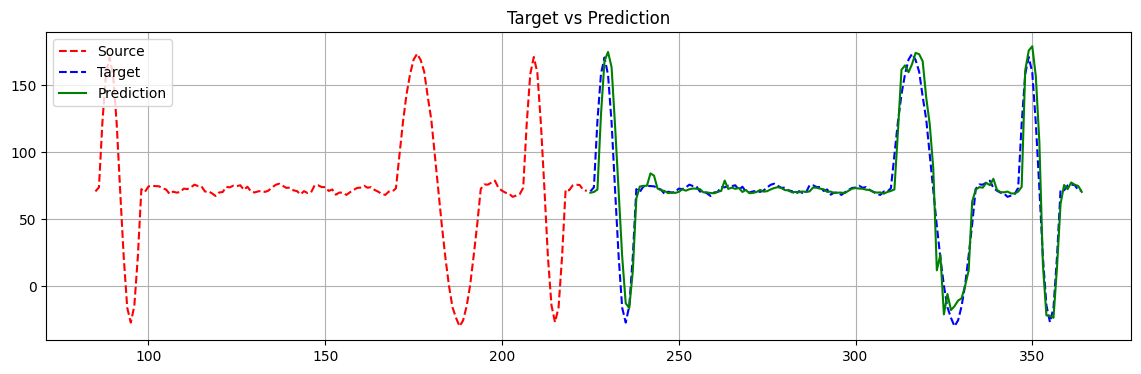

In [45]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 5: One-step and N-step prediction using *one head* and the *cosine* distance function.

### Training setup

In [46]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = cosine                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [47]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2678.1752	val_loss=1483.0627	train_mape_loss=1.7889	val_mape_loss=2.2565	R_p=['0.2767', '0.2558']
epoch=1	train_loss=1473.6676	val_loss=1386.3760	train_mape_loss=2.0671	val_mape_loss=2.1256	R_p=['0.2803', '0.2675']
epoch=2	train_loss=1430.4482	val_loss=1323.2536	train_mape_loss=2.0118	val_mape_loss=2.0507	R_p=['0.2853', '0.2738']
epoch=3	train_loss=1351.2512	val_loss=1201.7041	train_mape_loss=1.9155	val_mape_loss=1.9310	R_p=['0.2927', '0.2588']
epoch=4	train_loss=1207.8835	val_loss=1050.0449	train_mape_loss=1.7058	val_mape_loss=1.6733	R_p=['0.3066', '0.2571']
epoch=5	train_loss=1065.6974	val_loss=961.8119	train_mape_loss=1.4526	val_mape_loss=1.4720	R_p=['0.3000', '0.2426']
epoch=6	train_loss=961.6269	val_loss=858.2568	train_mape_loss=1.2387	val_mape_loss=1.2349	R_p=['0.2873', '0.2614']
epoch=7	train_loss=871.1207	val_loss=791.0049	train_mape_loss=1.0376	val_mape_loss=1.0392	R_p=['0.2819', '0.2525']
epoch=8	train_loss=813.1315	val_loss=765.6104	train_mape_loss=0.9106	

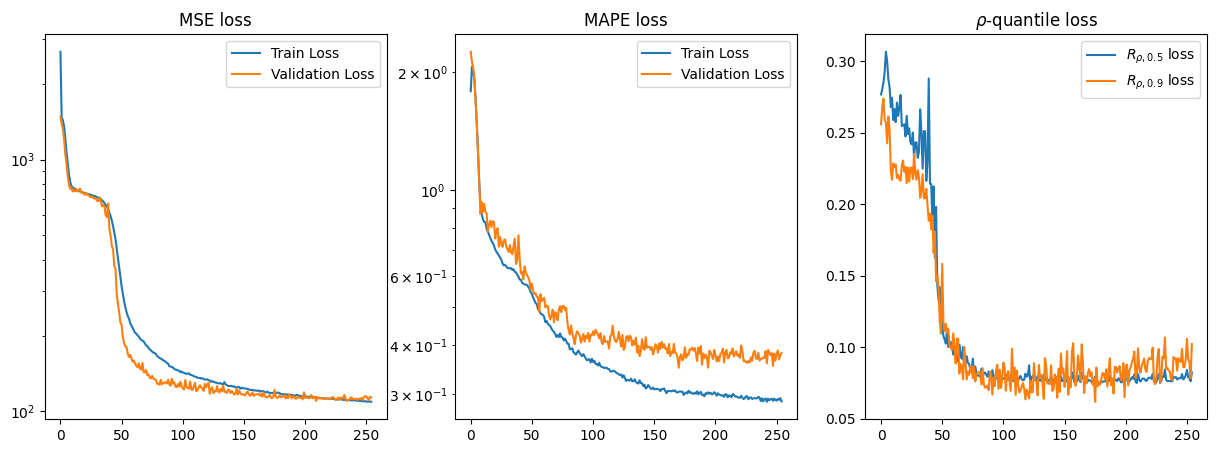

In [48]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [49]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(113.5552998046875,
 0.3625842089653015,
 [0.08270645141601562, 0.10231567919254303])

### N-step prediction

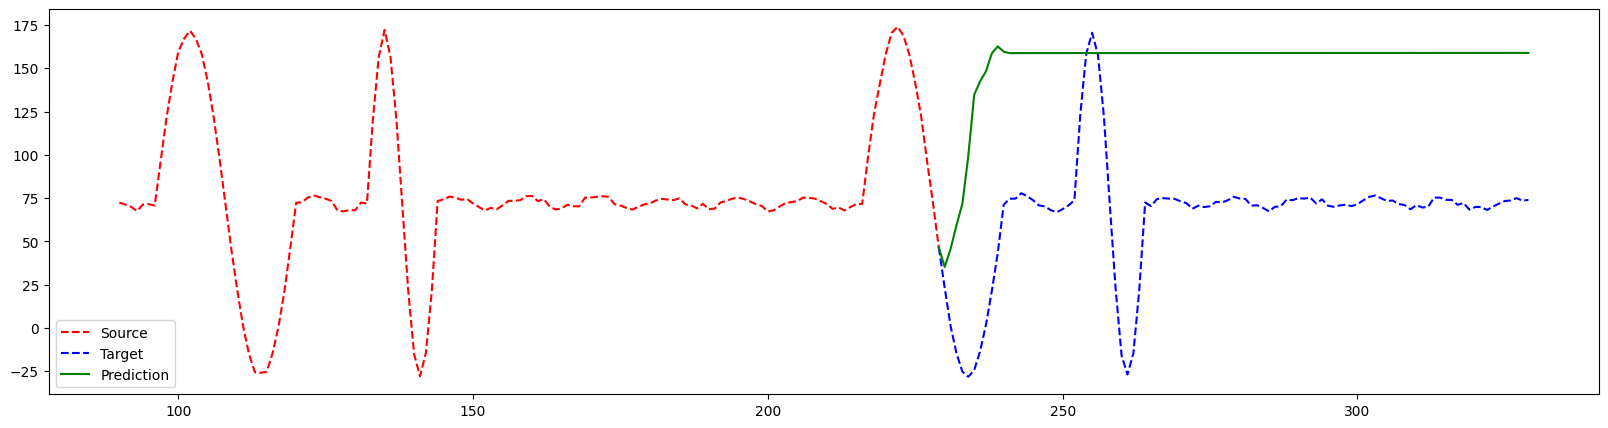

In [50]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

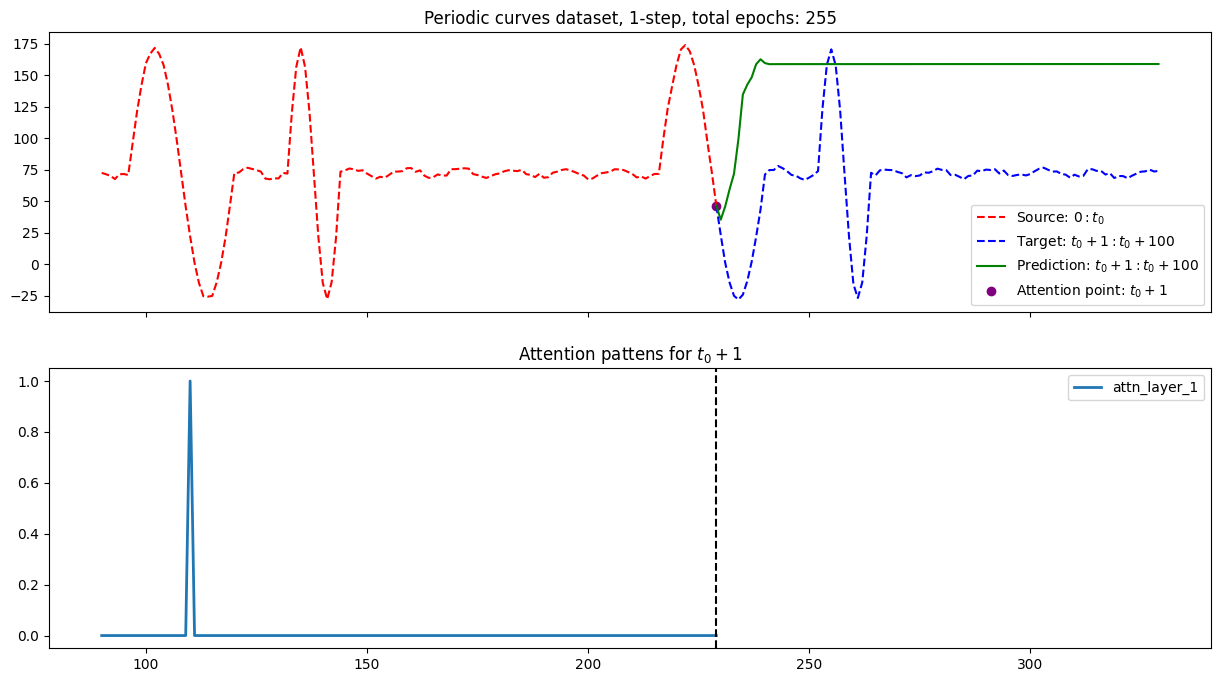

In [51]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

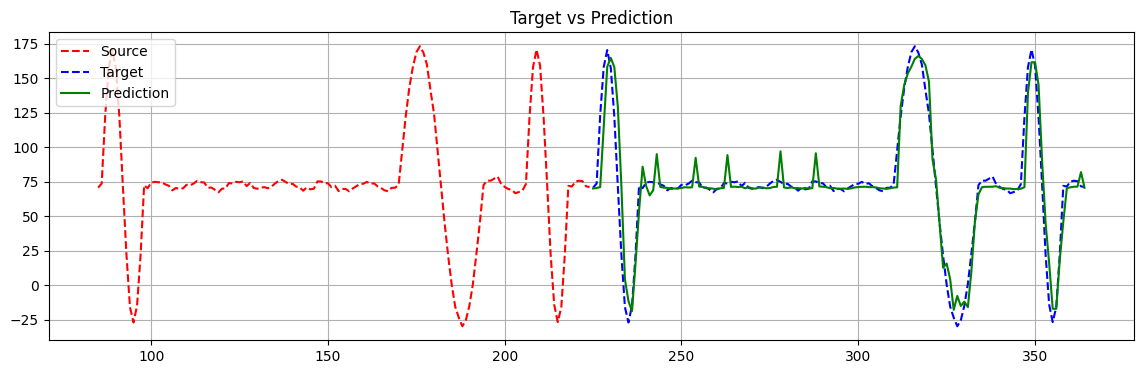

In [52]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 6: One-step and N-step prediction using *two heads* and the *cosine* distance function.

### Training setup

In [53]:
n_heads = 2                               # Number of heads used in multi headed simplex attention
distance_metric = cosine                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [54]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2696.7549	val_loss=1470.2232	train_mape_loss=1.7891	val_mape_loss=2.2424	R_p=['0.2757', '0.2562']
epoch=1	train_loss=1471.0686	val_loss=1387.2191	train_mape_loss=2.0655	val_mape_loss=2.1580	R_p=['0.2815', '0.2542']
epoch=2	train_loss=1428.4306	val_loss=1326.0862	train_mape_loss=2.0120	val_mape_loss=2.0618	R_p=['0.2861', '0.2682']
epoch=3	train_loss=1344.4172	val_loss=1205.1495	train_mape_loss=1.9080	val_mape_loss=1.9480	R_p=['0.2925', '0.2510']
epoch=4	train_loss=1187.7650	val_loss=1052.9141	train_mape_loss=1.6843	val_mape_loss=1.6857	R_p=['0.3068', '0.2426']
epoch=5	train_loss=1048.5669	val_loss=923.7193	train_mape_loss=1.4325	val_mape_loss=1.2498	R_p=['0.2996', '0.2974']
epoch=6	train_loss=950.5635	val_loss=870.7019	train_mape_loss=1.2243	val_mape_loss=1.1751	R_p=['0.2947', '0.2449']
epoch=7	train_loss=864.7738	val_loss=813.6508	train_mape_loss=1.0580	val_mape_loss=1.0592	R_p=['0.2804', '0.2339']
epoch=8	train_loss=805.3149	val_loss=785.8149	train_mape_loss=0.9326	

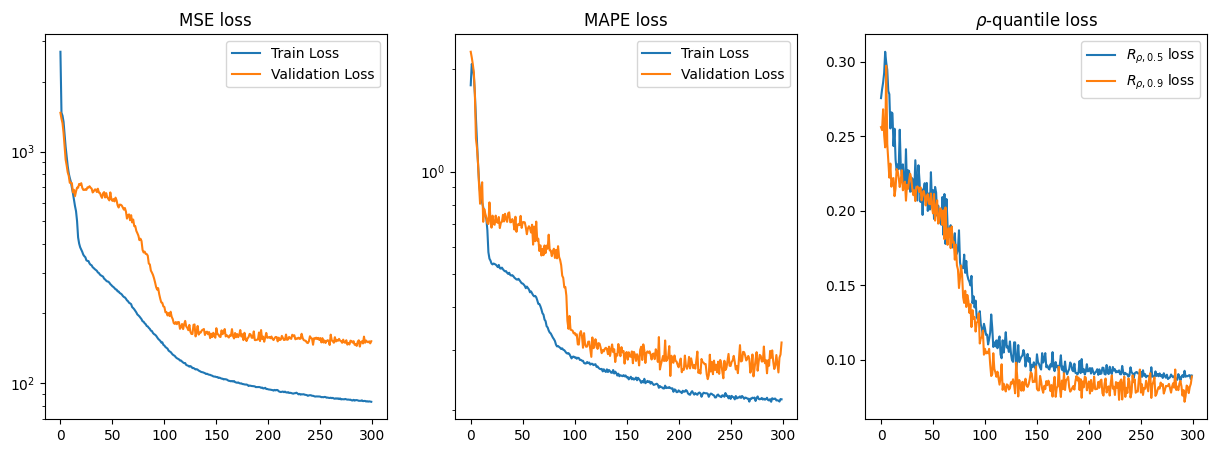

In [55]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [56]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(157.9317127685547,
 0.32260248613357545,
 [0.09260282665491104, 0.08334796130657196])

### N-step prediction

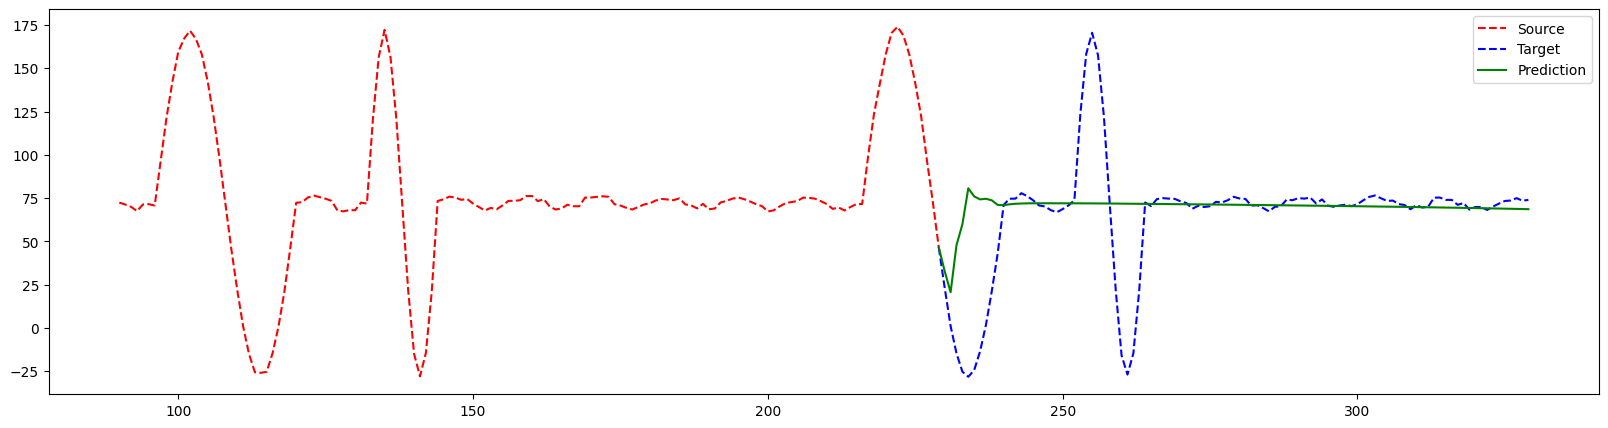

In [57]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

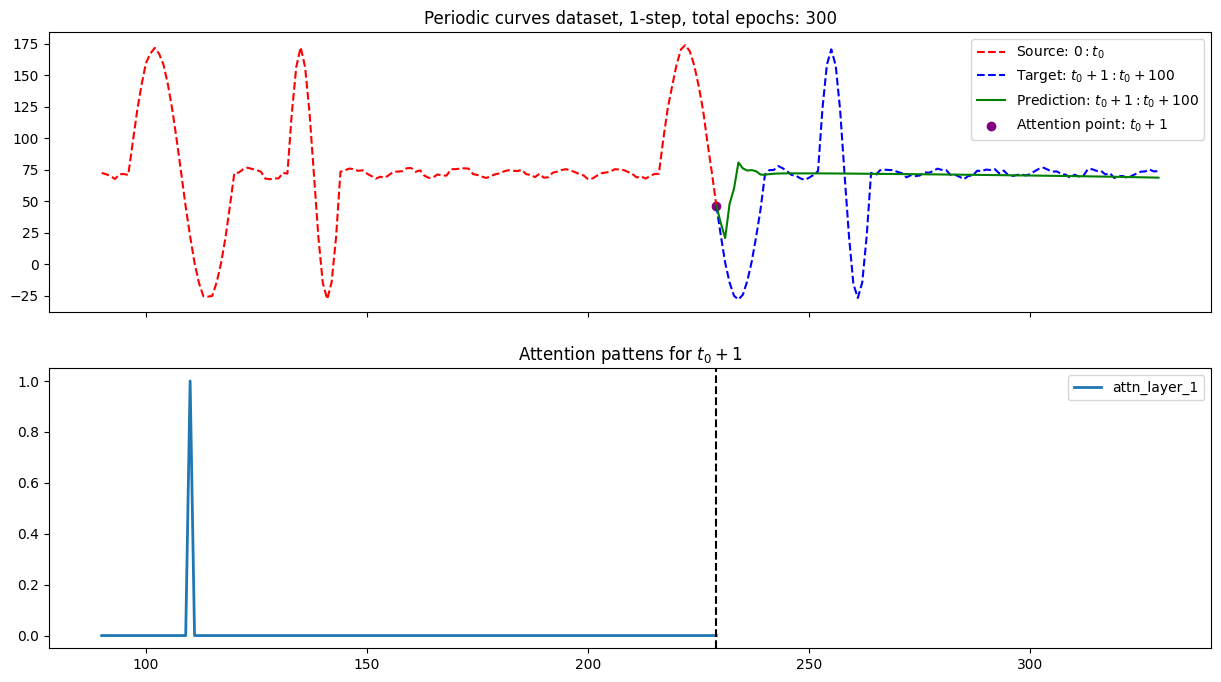

In [58]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

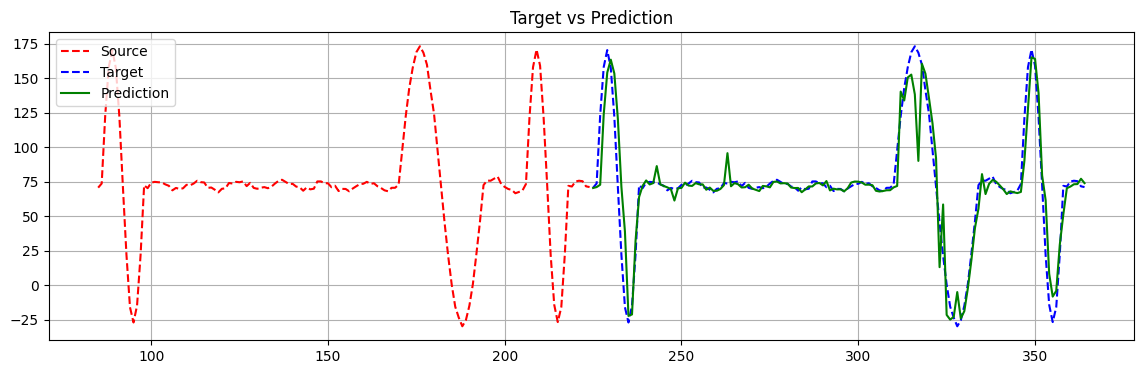

In [59]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 7: One-step and N-step prediction using *four heads* and the *cosine* distance function.

### Training setup

In [60]:
n_heads = 4                               # Number of heads used in multi headed simplex attention
distance_metric = cosine                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [61]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2846.2742	val_loss=1454.8911	train_mape_loss=1.7785	val_mape_loss=2.2215	R_p=['0.2747', '0.2579']
epoch=1	train_loss=1470.1159	val_loss=1390.7031	train_mape_loss=2.0665	val_mape_loss=2.1562	R_p=['0.2802', '0.2578']
epoch=2	train_loss=1437.9026	val_loss=1350.5011	train_mape_loss=2.0244	val_mape_loss=2.1319	R_p=['0.2840', '0.2516']
epoch=3	train_loss=1369.1025	val_loss=1266.8938	train_mape_loss=1.9426	val_mape_loss=2.0656	R_p=['0.2953', '0.2370']
epoch=4	train_loss=1226.1635	val_loss=1058.1833	train_mape_loss=1.7563	val_mape_loss=1.6938	R_p=['0.3003', '0.2670']
epoch=5	train_loss=1055.1007	val_loss=947.4847	train_mape_loss=1.4657	val_mape_loss=1.4017	R_p=['0.2991', '0.2591']
epoch=6	train_loss=937.7822	val_loss=888.5137	train_mape_loss=1.2208	val_mape_loss=1.2332	R_p=['0.2971', '0.2373']
epoch=7	train_loss=824.1219	val_loss=793.0442	train_mape_loss=1.0419	val_mape_loss=0.9722	R_p=['0.2721', '0.2475']
epoch=8	train_loss=721.2835	val_loss=807.3164	train_mape_loss=0.8969	

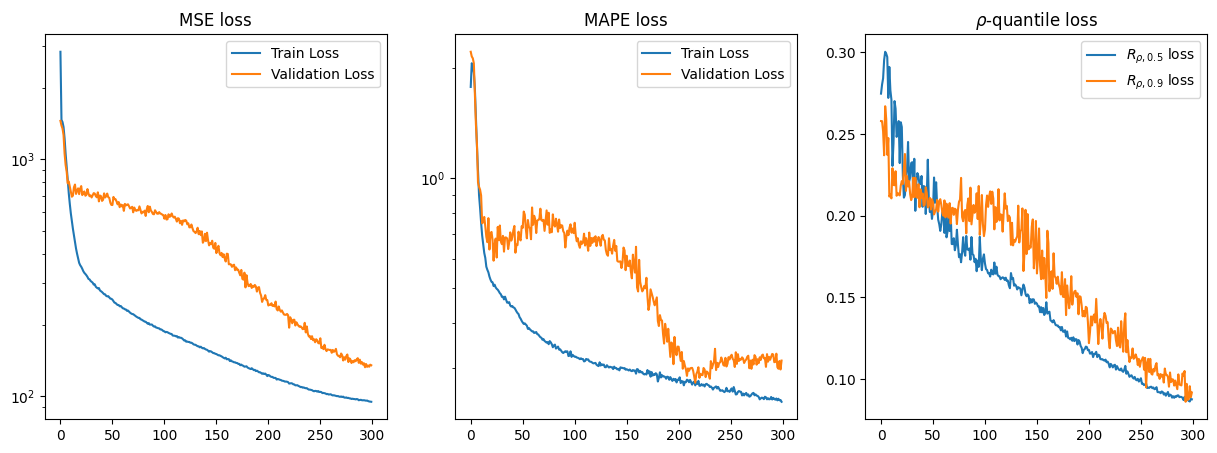

In [62]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [63]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(134.82068994140624,
 0.3189627499580383,
 [0.08847101777791977, 0.08954501897096634])

### N-step prediction

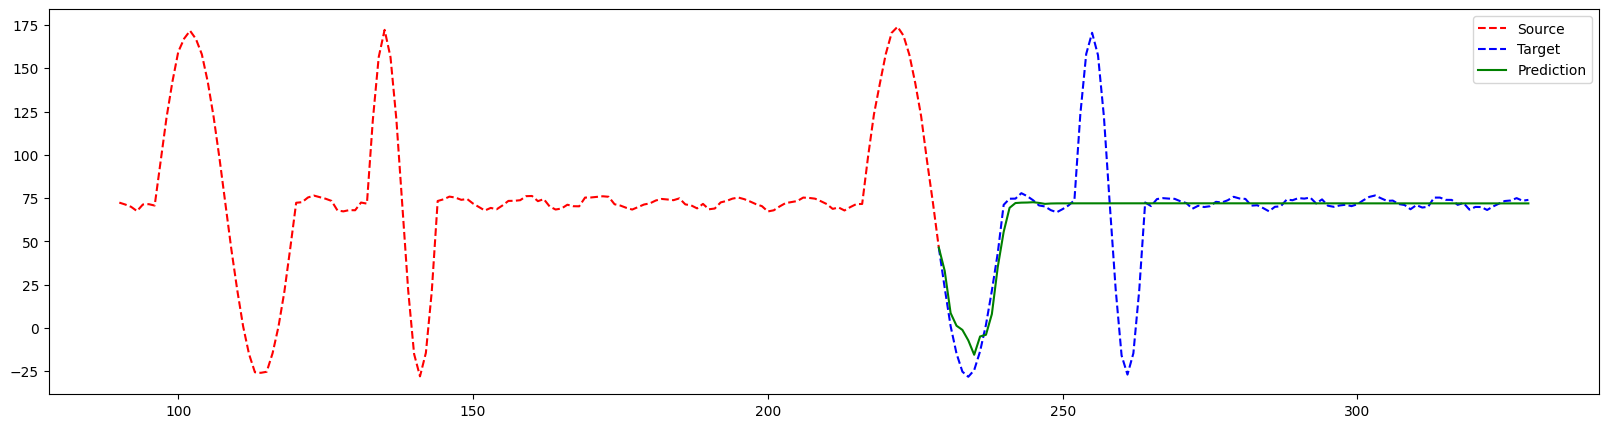

In [64]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

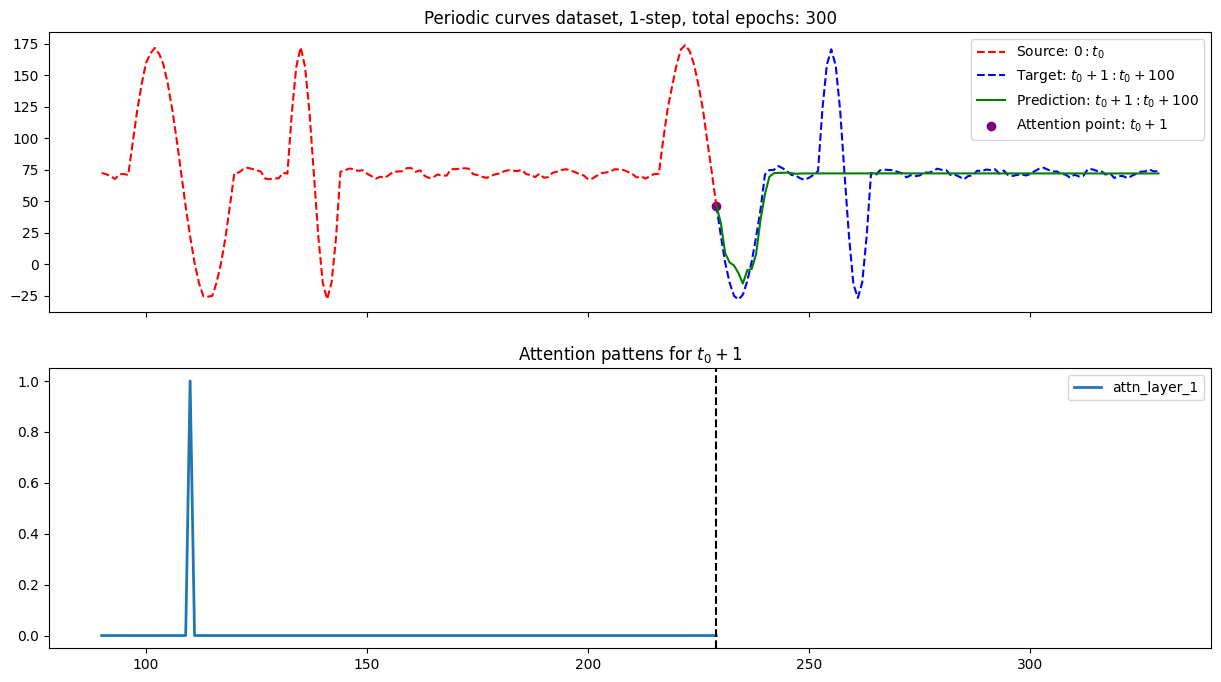

In [65]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

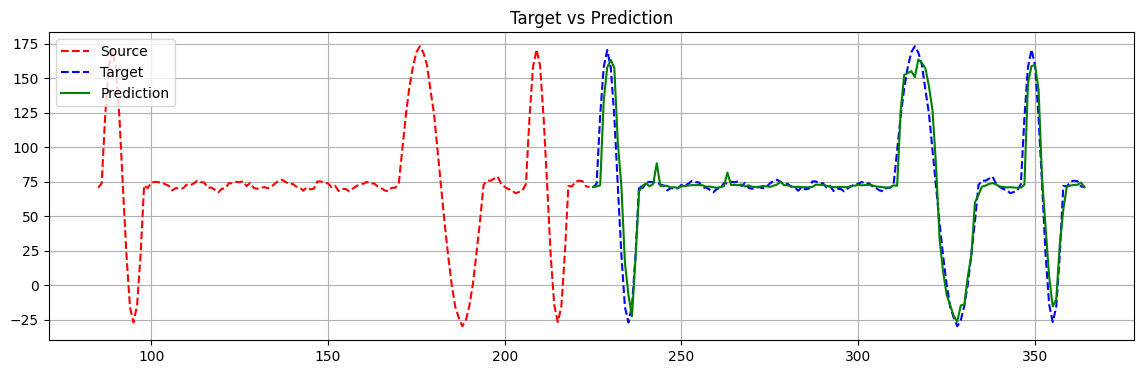

In [66]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 8: One-step and N-step prediction using *eight heads* and the *cosine* distance function.

### Training setup

In [67]:
n_heads = 8                               # Number of heads used in multi headed simplex attention
distance_metric = cosine                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [68]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2784.2730	val_loss=1444.6346	train_mape_loss=1.7774	val_mape_loss=2.2096	R_p=['0.2739', '0.2583']
epoch=1	train_loss=1461.0344	val_loss=1353.9234	train_mape_loss=2.0573	val_mape_loss=2.1339	R_p=['0.2812', '0.2536']
epoch=2	train_loss=1400.7901	val_loss=1246.2065	train_mape_loss=1.9856	val_mape_loss=1.9995	R_p=['0.2858', '0.2551']
epoch=3	train_loss=1284.2350	val_loss=1061.8765	train_mape_loss=1.8344	val_mape_loss=1.6329	R_p=['0.2998', '0.3009']
epoch=4	train_loss=1124.6554	val_loss=953.3924	train_mape_loss=1.5828	val_mape_loss=1.4396	R_p=['0.2953', '0.2578']
epoch=5	train_loss=984.3135	val_loss=863.2431	train_mape_loss=1.3066	val_mape_loss=1.1412	R_p=['0.2967', '0.2477']
epoch=6	train_loss=854.8936	val_loss=765.5743	train_mape_loss=1.0558	val_mape_loss=0.8316	R_p=['0.2679', '0.2446']
epoch=7	train_loss=763.0097	val_loss=753.0602	train_mape_loss=0.9352	val_mape_loss=0.8432	R_p=['0.2665', '0.2233']
epoch=8	train_loss=694.3726	val_loss=756.7577	train_mape_loss=0.8669	va

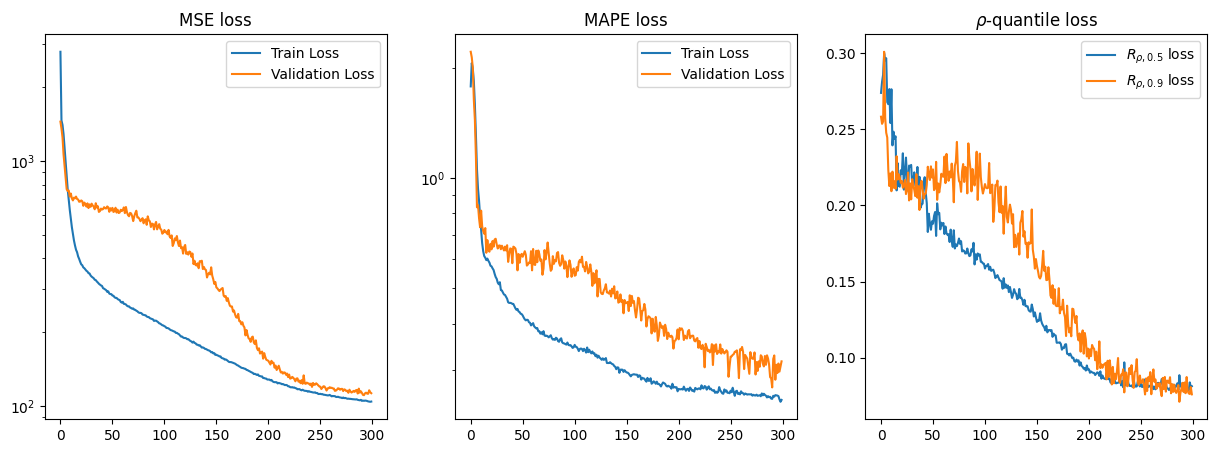

In [69]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [70]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(112.89234600830078,
 0.3028176286220551,
 [0.08238116651773453, 0.07278241217136383])

### N-step prediction

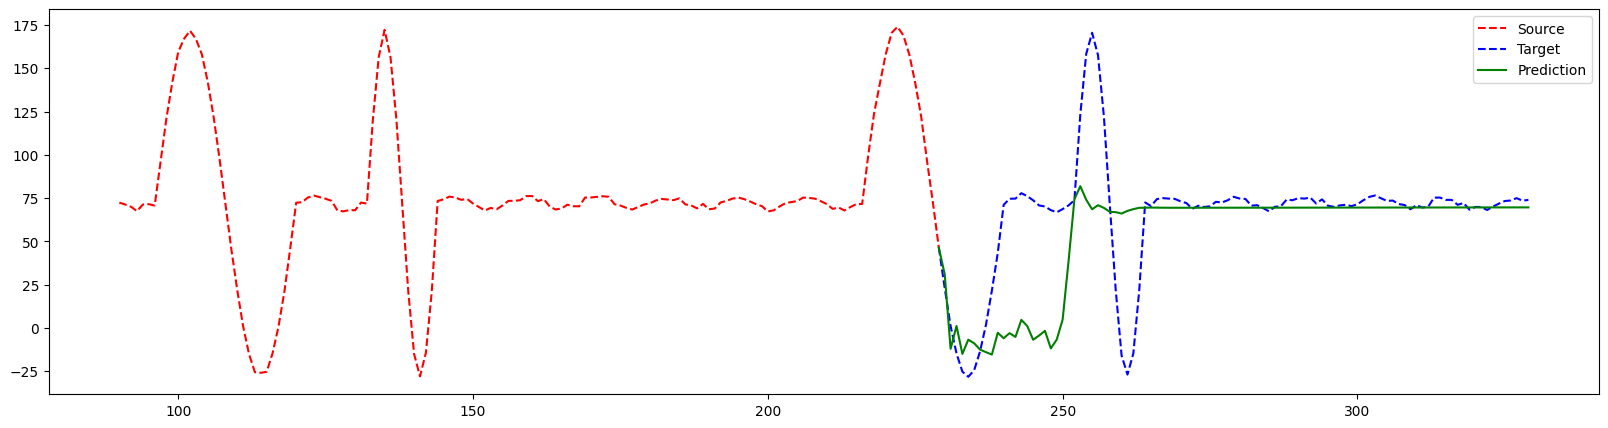

In [71]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

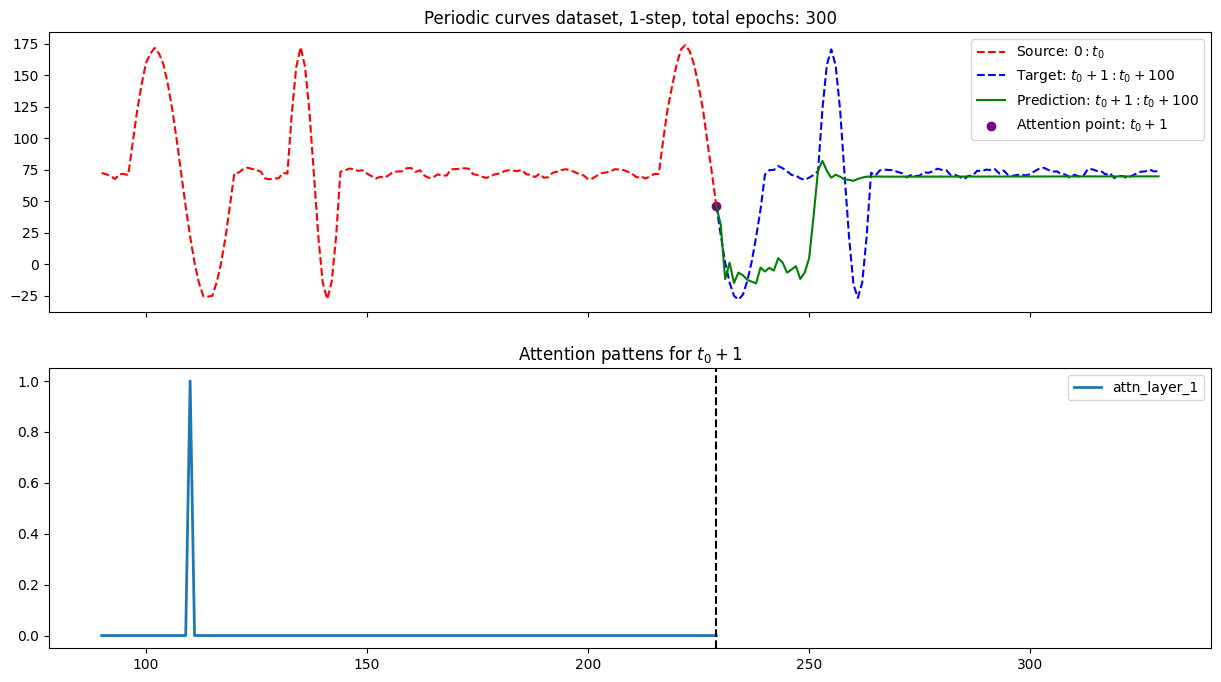

In [72]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

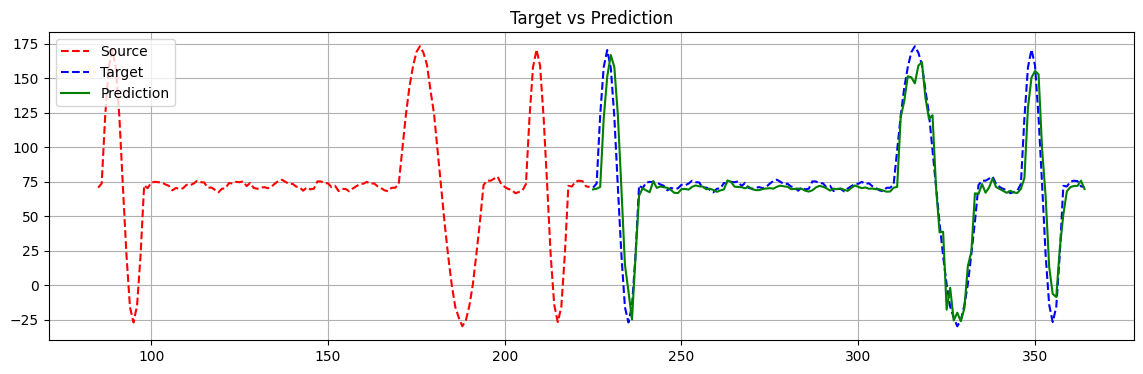

In [73]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 9: One-step and N-step prediction using *one head* and the *manhatten* distance function.

### Training setup

In [74]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = manhattan                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [75]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2950.1512	val_loss=1467.1225	train_mape_loss=1.7551	val_mape_loss=2.2158	R_p=['0.2749', '0.2626']
epoch=1	train_loss=1483.3412	val_loss=1434.0415	train_mape_loss=2.0772	val_mape_loss=2.1447	R_p=['0.2823', '0.2841']
epoch=2	train_loss=1467.2506	val_loss=1398.7103	train_mape_loss=2.0588	val_mape_loss=2.0884	R_p=['0.2886', '0.2933']
epoch=3	train_loss=1425.5053	val_loss=1326.4187	train_mape_loss=2.0120	val_mape_loss=2.0426	R_p=['0.2927', '0.2798']
epoch=4	train_loss=1332.1359	val_loss=1200.2822	train_mape_loss=1.9054	val_mape_loss=1.9207	R_p=['0.2983', '0.2665']
epoch=5	train_loss=1179.1495	val_loss=986.1477	train_mape_loss=1.6694	val_mape_loss=1.5537	R_p=['0.2943', '0.2686']
epoch=6	train_loss=1034.6118	val_loss=905.1198	train_mape_loss=1.3514	val_mape_loss=1.1947	R_p=['0.2889', '0.2553']
epoch=7	train_loss=960.0748	val_loss=840.9482	train_mape_loss=1.1847	val_mape_loss=1.0182	R_p=['0.2618', '0.2486']
epoch=8	train_loss=903.8556	val_loss=806.2853	train_mape_loss=1.1082

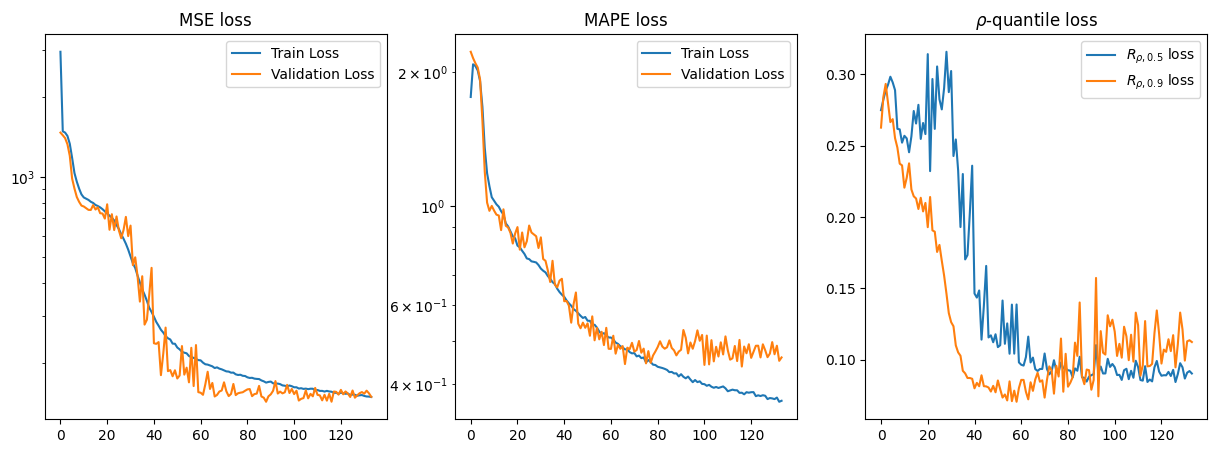

In [76]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [77]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(146.69066564941406,
 0.43570034551620485,
 [0.08812122046947479, 0.10610239952802658])

### N-step prediction

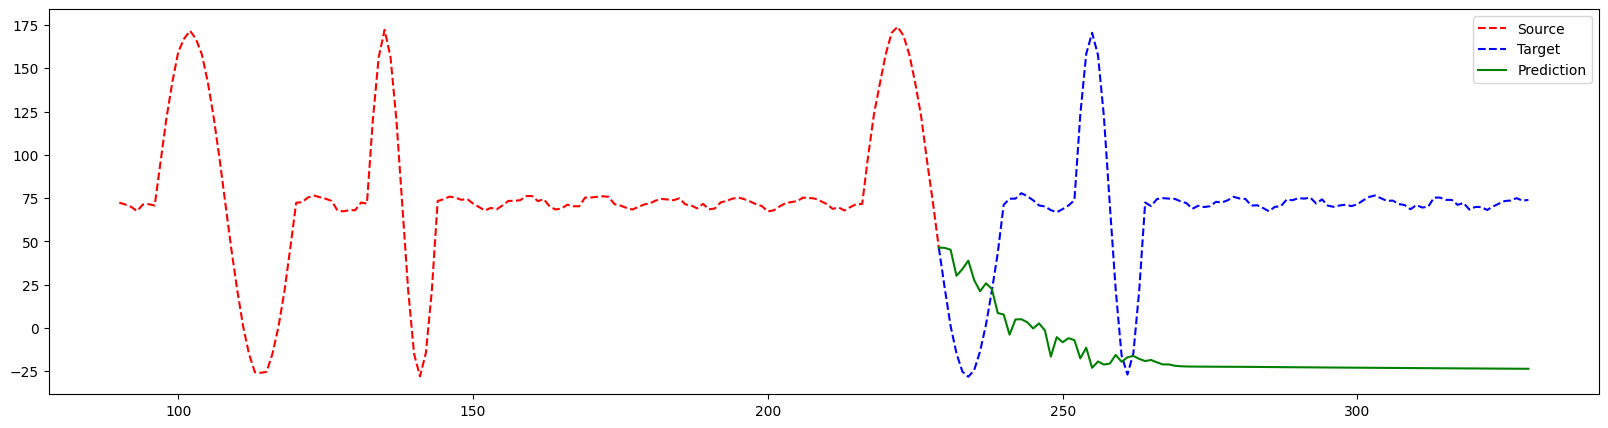

In [78]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

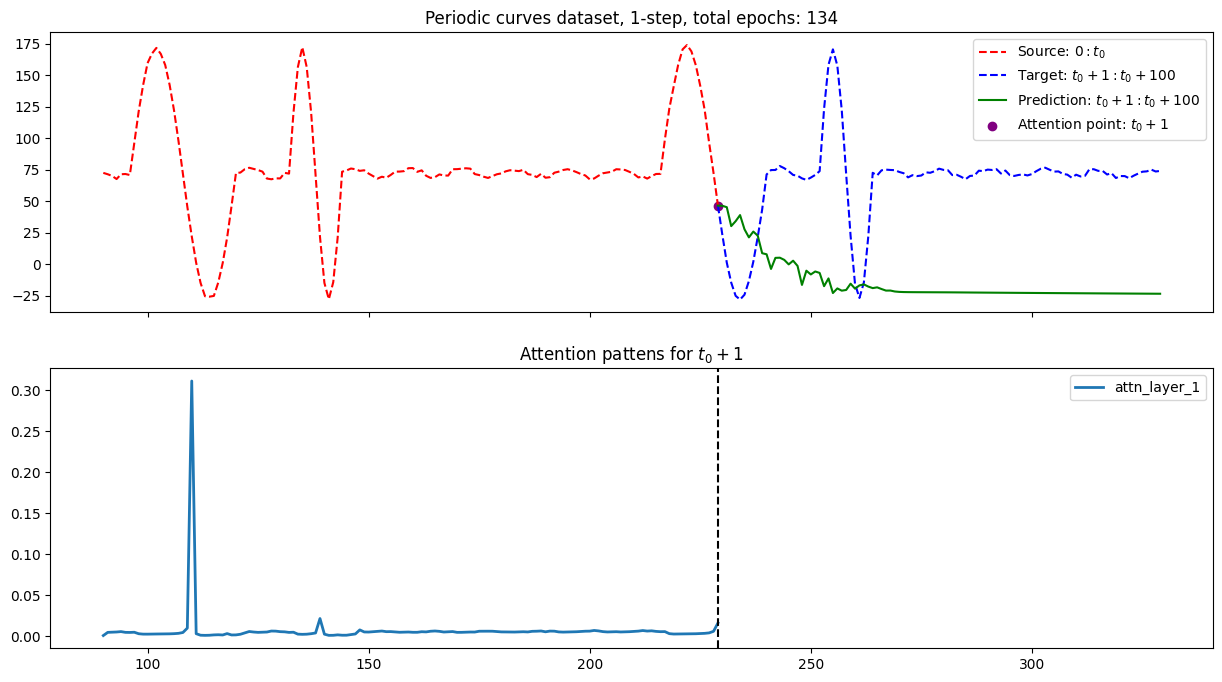

In [79]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

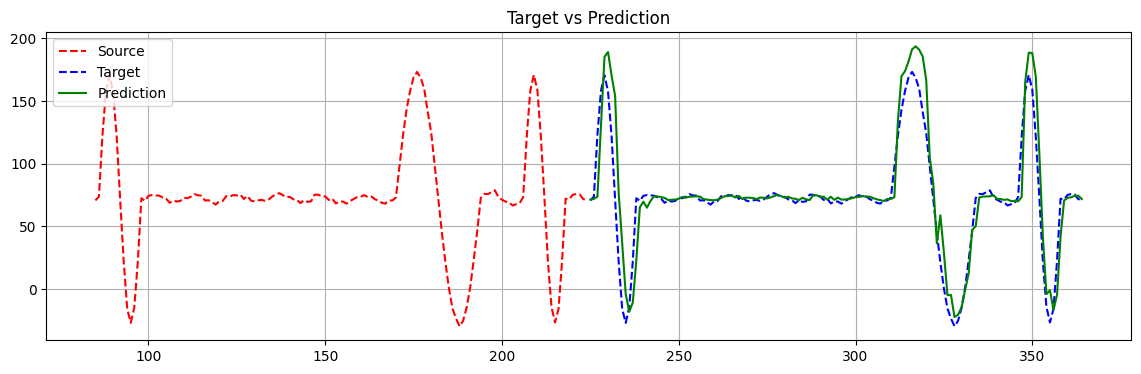

In [80]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 10: One-step and N-step prediction using *two heads* and the *manattan* distance function.

### Training setup

In [81]:
n_heads = 2                               # Number of heads used in multi headed simplex attention
distance_metric = manhattan                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [82]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2744.6375	val_loss=1461.5872	train_mape_loss=1.7804	val_mape_loss=2.2180	R_p=['0.2757', '0.2607']
epoch=1	train_loss=1479.5267	val_loss=1429.9590	train_mape_loss=2.0766	val_mape_loss=2.1967	R_p=['0.2820', '0.2609']
epoch=2	train_loss=1460.9124	val_loss=1389.3975	train_mape_loss=2.0536	val_mape_loss=2.1710	R_p=['0.2857', '0.2556']
epoch=3	train_loss=1404.0541	val_loss=1293.6156	train_mape_loss=1.9898	val_mape_loss=1.9852	R_p=['0.2955', '0.2901']
epoch=4	train_loss=1267.6873	val_loss=1093.3967	train_mape_loss=1.8185	val_mape_loss=1.7216	R_p=['0.2949', '0.2684']
epoch=5	train_loss=1066.4297	val_loss=913.8489	train_mape_loss=1.4429	val_mape_loss=1.2965	R_p=['0.2880', '0.2691']
epoch=6	train_loss=945.9855	val_loss=861.1670	train_mape_loss=1.1736	val_mape_loss=1.1532	R_p=['0.2694', '0.2337']
epoch=7	train_loss=877.4990	val_loss=795.6730	train_mape_loss=1.0487	val_mape_loss=0.9600	R_p=['0.2690', '0.2261']
epoch=8	train_loss=797.5905	val_loss=708.3381	train_mape_loss=0.9760	

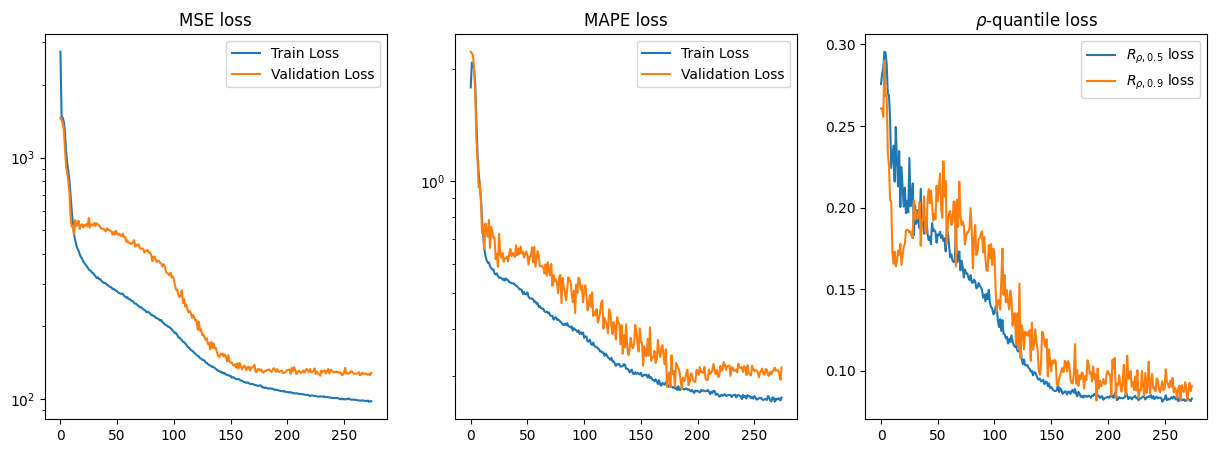

In [83]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [84]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(130.09678021240234,
 0.3125022563934326,
 [0.08395842462778091, 0.09026189893484116])

### N-step prediction

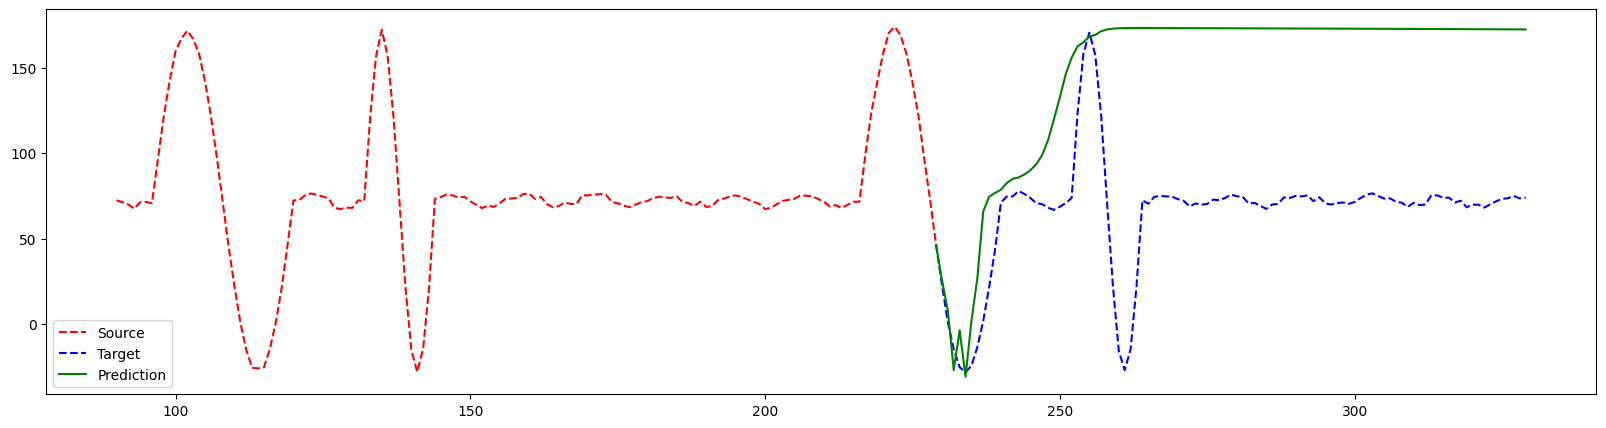

In [85]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

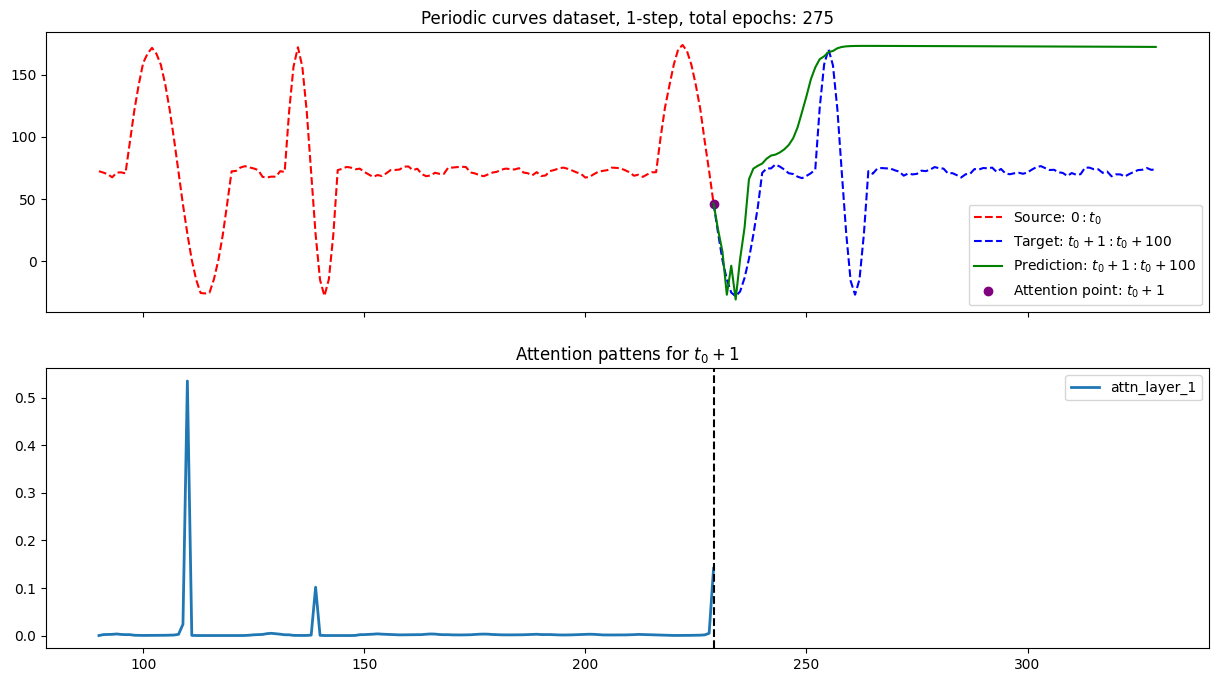

In [86]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

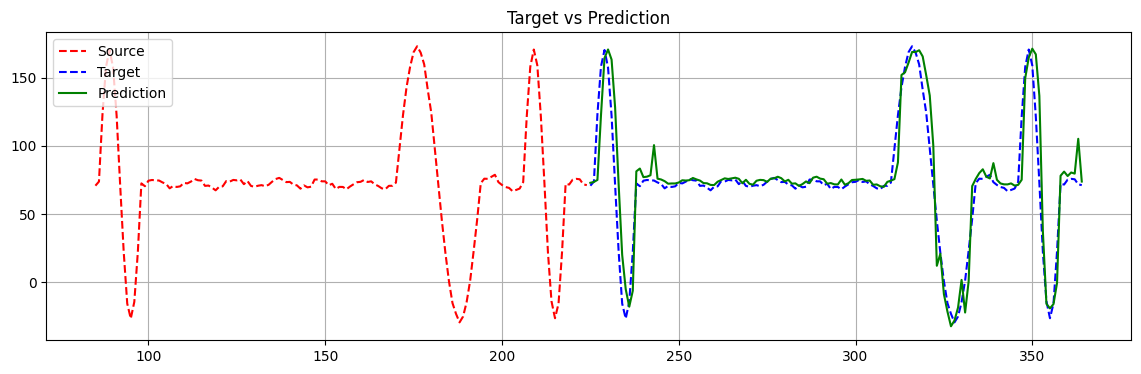

In [87]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 11: One-step and N-step prediction using *four heads* and the *manattan* distance function.

In [88]:
n_heads = 4                               # Number of heads used in multi headed simplex attention
distance_metric = manhattan                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [89]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2814.0713	val_loss=1457.1064	train_mape_loss=1.7748	val_mape_loss=2.2130	R_p=['0.2757', '0.2611']
epoch=1	train_loss=1475.1396	val_loss=1418.6730	train_mape_loss=2.0710	val_mape_loss=2.1686	R_p=['0.2820', '0.2669']
epoch=2	train_loss=1448.5636	val_loss=1360.0572	train_mape_loss=2.0395	val_mape_loss=2.1329	R_p=['0.2881', '0.2602']
epoch=3	train_loss=1362.8910	val_loss=1234.6293	train_mape_loss=1.9382	val_mape_loss=1.9527	R_p=['0.2974', '0.2684']
epoch=4	train_loss=1206.1208	val_loss=1043.8692	train_mape_loss=1.7255	val_mape_loss=1.5931	R_p=['0.3042', '0.2714']
epoch=5	train_loss=1034.1882	val_loss=898.9739	train_mape_loss=1.3790	val_mape_loss=1.1427	R_p=['0.2839', '0.2750']
epoch=6	train_loss=923.6352	val_loss=831.7212	train_mape_loss=1.1439	val_mape_loss=1.1377	R_p=['0.2748', '0.2283']
epoch=7	train_loss=839.2280	val_loss=741.5847	train_mape_loss=1.0050	val_mape_loss=0.9450	R_p=['0.2539', '0.2309']
epoch=8	train_loss=749.0324	val_loss=625.5159	train_mape_loss=0.9210	

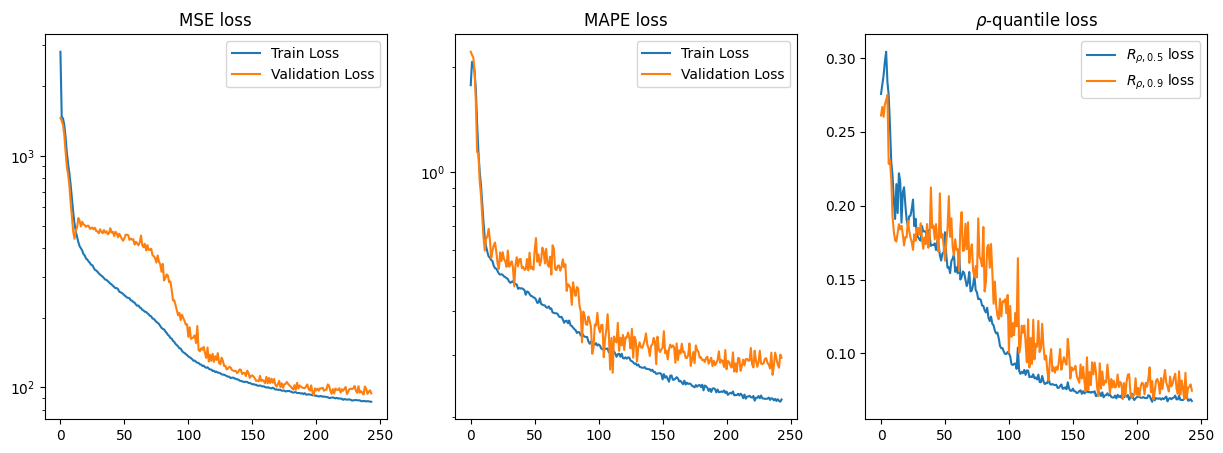

In [90]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [91]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(93.71691632080078,
 0.28010921263694766,
 [0.0684509351849556, 0.07397285848855972])

### N-step prediction

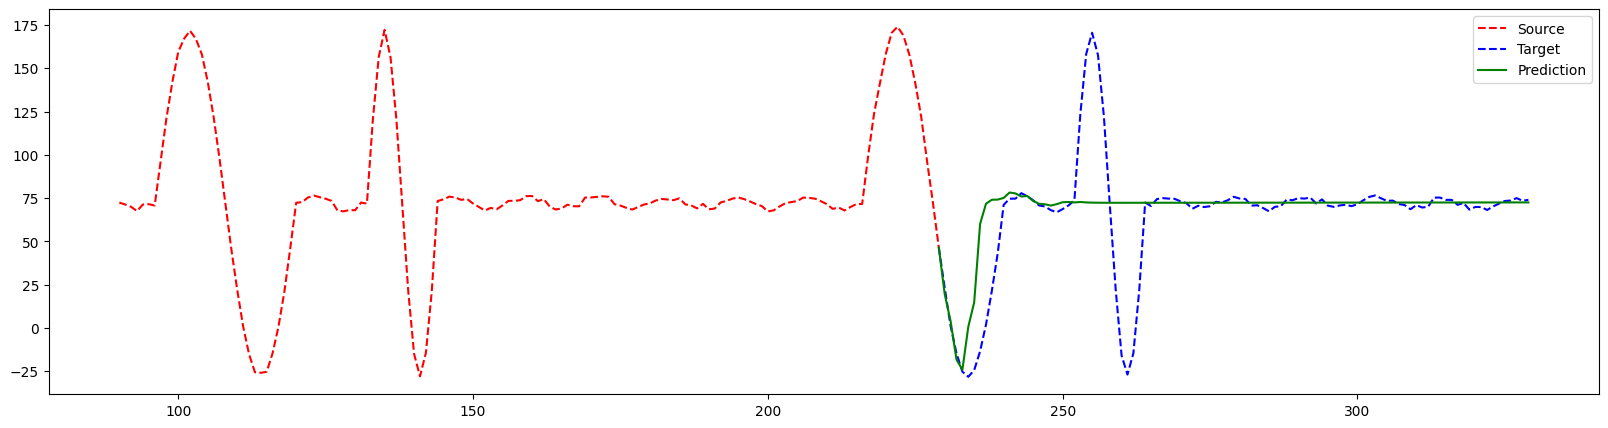

In [92]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

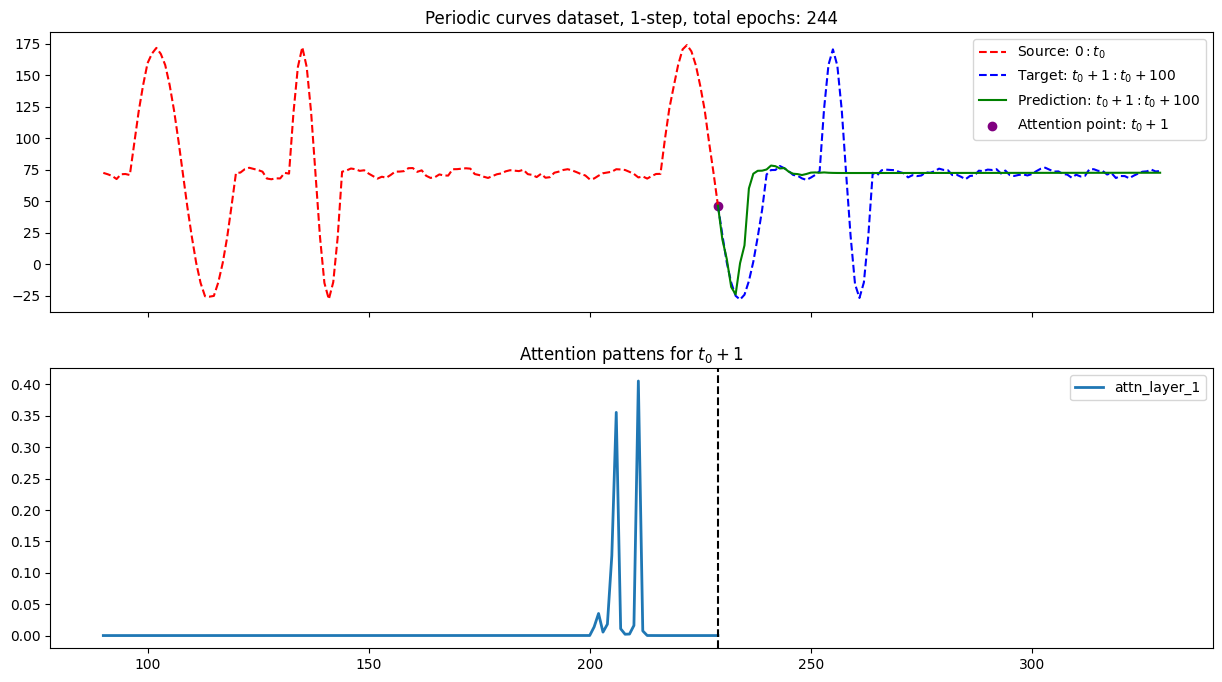

In [93]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

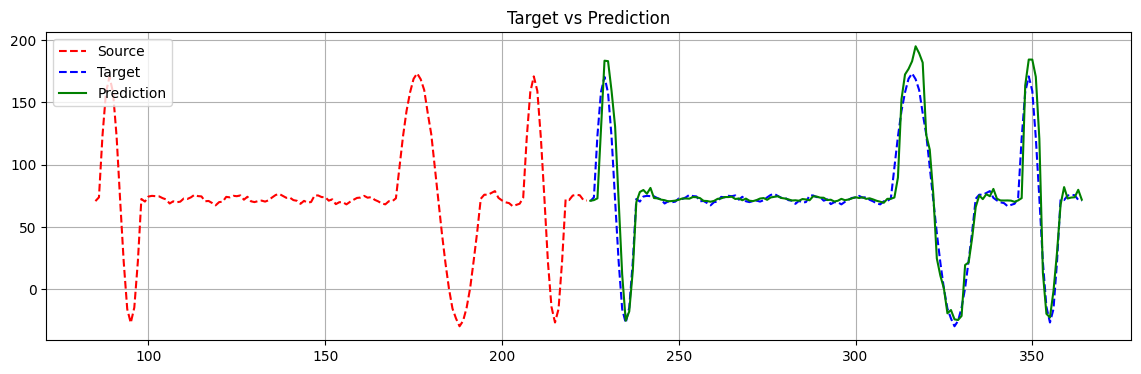

In [94]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 12: One-step and N-step prediction using *eight heads* and the *manattan* distance function.

In [95]:
n_heads = 8                               # Number of heads used in multi headed simplex attention
distance_metric = manhattan                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [96]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=3008.4592	val_loss=1475.3847	train_mape_loss=1.7562	val_mape_loss=2.2348	R_p=['0.2750', '0.2594']
epoch=1	train_loss=1485.3448	val_loss=1436.4257	train_mape_loss=2.0796	val_mape_loss=2.2157	R_p=['0.2820', '0.2544']
epoch=2	train_loss=1473.8902	val_loss=1403.3884	train_mape_loss=2.0690	val_mape_loss=2.1407	R_p=['0.2802', '0.2703']
epoch=3	train_loss=1450.6581	val_loss=1322.8539	train_mape_loss=2.0412	val_mape_loss=2.0571	R_p=['0.2858', '0.2753']
epoch=4	train_loss=1380.3357	val_loss=1170.9737	train_mape_loss=1.9674	val_mape_loss=1.8876	R_p=['0.2909', '0.2679']
epoch=5	train_loss=1253.1962	val_loss=972.2694	train_mape_loss=1.7957	val_mape_loss=1.4341	R_p=['0.2960', '0.2951']
epoch=6	train_loss=1074.5083	val_loss=870.7838	train_mape_loss=1.4785	val_mape_loss=1.0716	R_p=['0.2789', '0.2753']
epoch=7	train_loss=949.2553	val_loss=815.6480	train_mape_loss=1.1870	val_mape_loss=0.9470	R_p=['0.2689', '0.2559']
epoch=8	train_loss=865.1453	val_loss=753.4693	train_mape_loss=1.0572

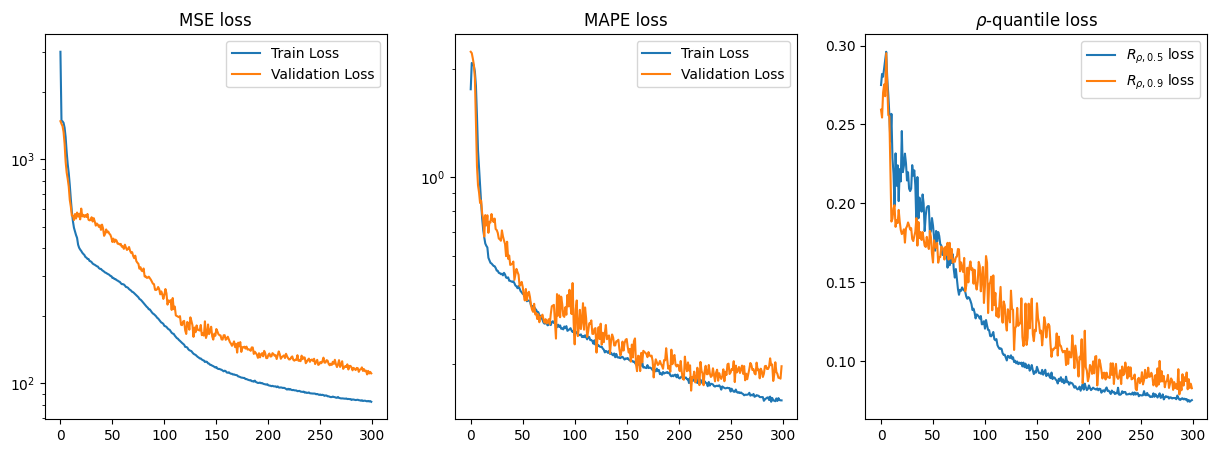

In [97]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [98]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(110.35536584472656,
 0.2882824685573578,
 [0.07594256848096848, 0.08106519281864166])

### N-step prediction

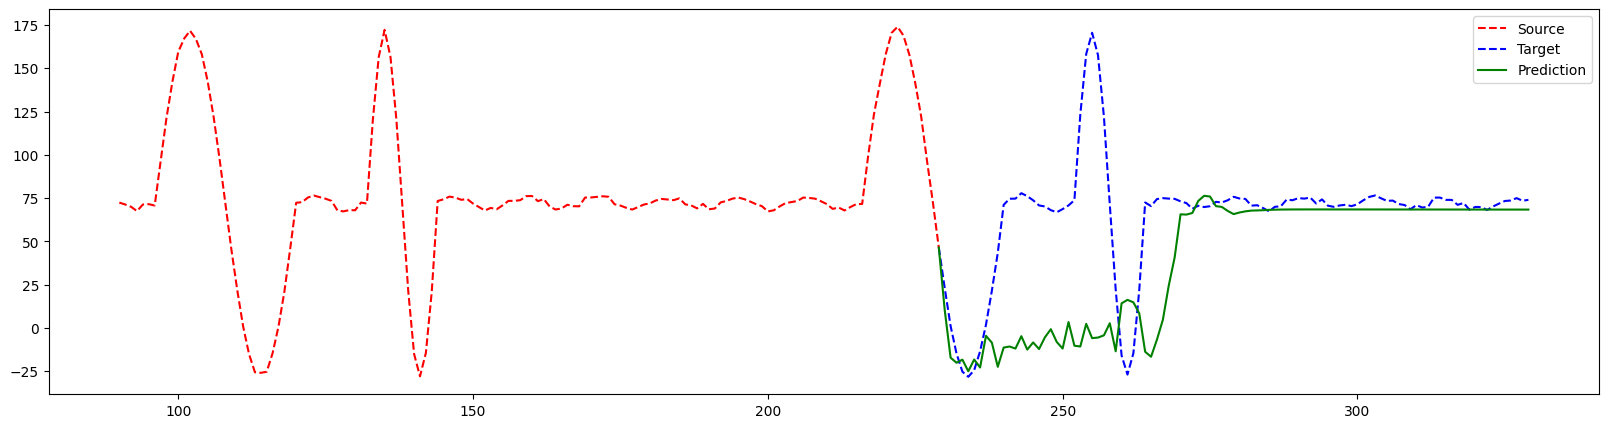

In [99]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

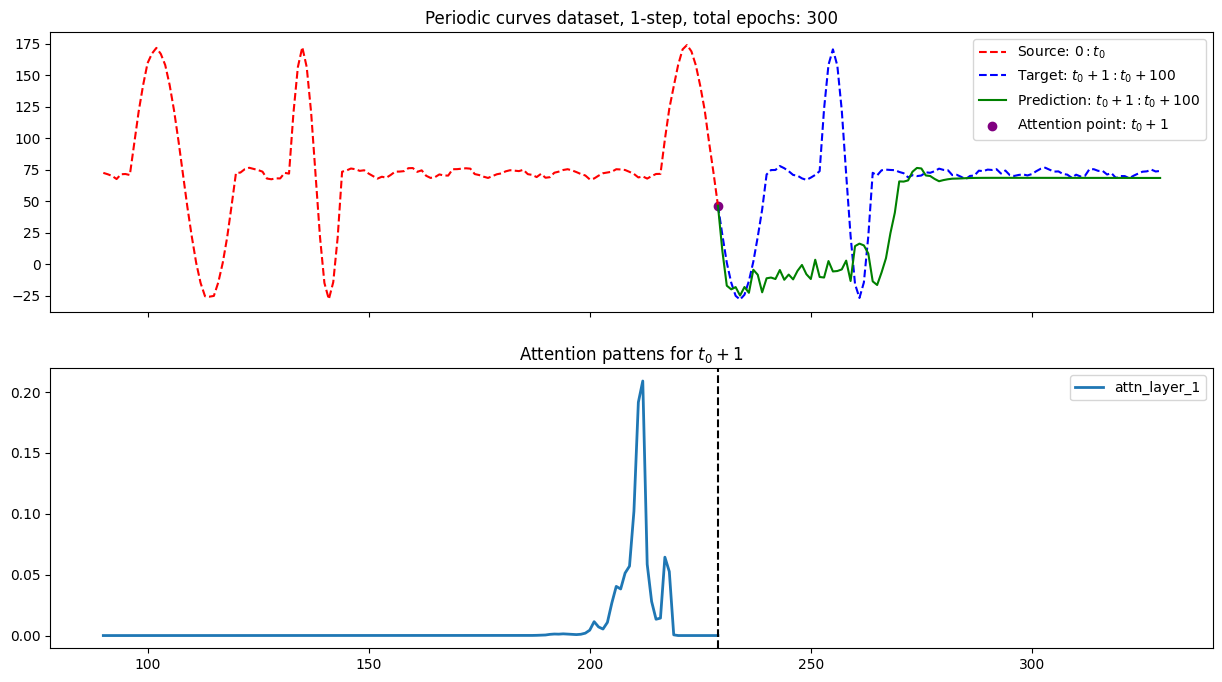

In [100]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

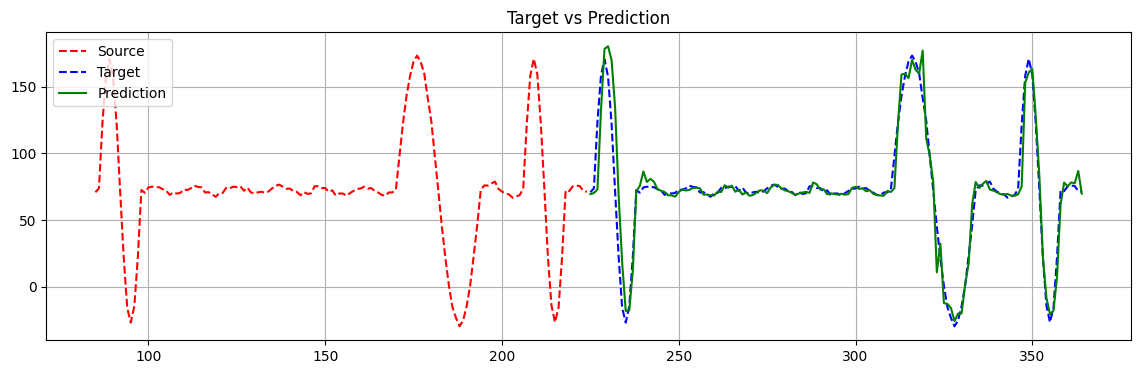

In [101]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 13: One-step and N-step prediction using *one head* and the *infinity norm* distance function.

In [102]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = infinity_norm                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [103]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2787.5496	val_loss=1470.6290	train_mape_loss=1.7749	val_mape_loss=2.2218	R_p=['0.2732', '0.2605']
epoch=1	train_loss=1480.0800	val_loss=1404.2590	train_mape_loss=2.0735	val_mape_loss=2.1698	R_p=['0.2794', '0.2587']
epoch=2	train_loss=1437.5852	val_loss=1352.7640	train_mape_loss=2.0286	val_mape_loss=2.1132	R_p=['0.2857', '0.2582']
epoch=3	train_loss=1367.1059	val_loss=1246.6766	train_mape_loss=1.9350	val_mape_loss=1.9498	R_p=['0.2943', '0.2769']
epoch=4	train_loss=1225.0921	val_loss=1045.7757	train_mape_loss=1.7483	val_mape_loss=1.6002	R_p=['0.2960', '0.2850']
epoch=5	train_loss=1034.4759	val_loss=909.5353	train_mape_loss=1.3970	val_mape_loss=1.3061	R_p=['0.2904', '0.2397']
epoch=6	train_loss=914.3028	val_loss=808.2327	train_mape_loss=1.0985	val_mape_loss=0.9725	R_p=['0.2664', '0.2521']
epoch=7	train_loss=838.1253	val_loss=756.3967	train_mape_loss=0.9473	val_mape_loss=0.8652	R_p=['0.2509', '0.2389']
epoch=8	train_loss=804.5739	val_loss=763.1976	train_mape_loss=0.9111	

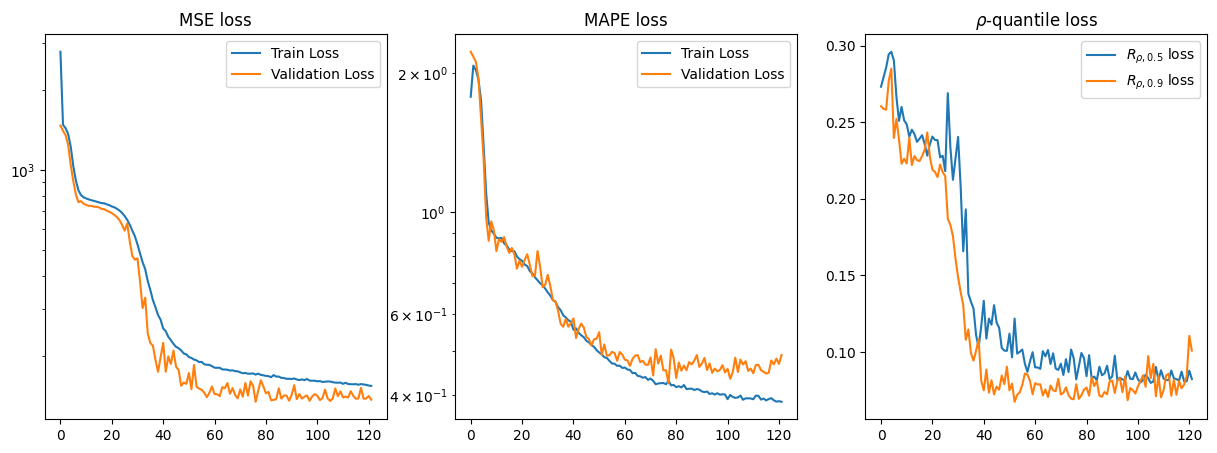

In [104]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [105]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(133.18278259277344,
 0.46943719005584716,
 [0.08059888333082199, 0.09476689994335175])

### N-step prediction

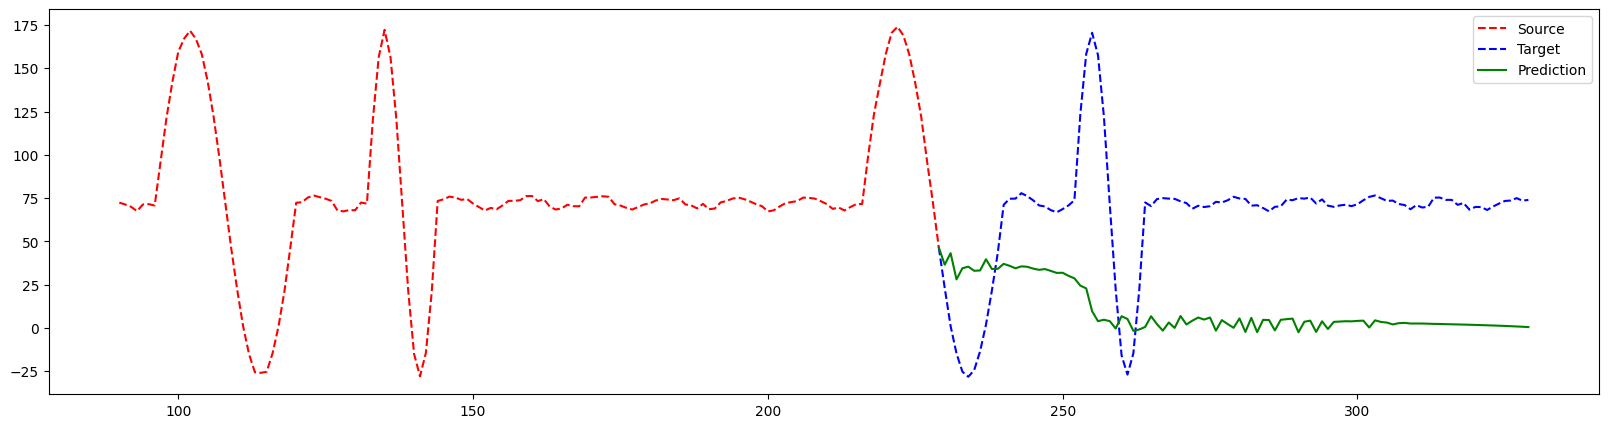

In [106]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

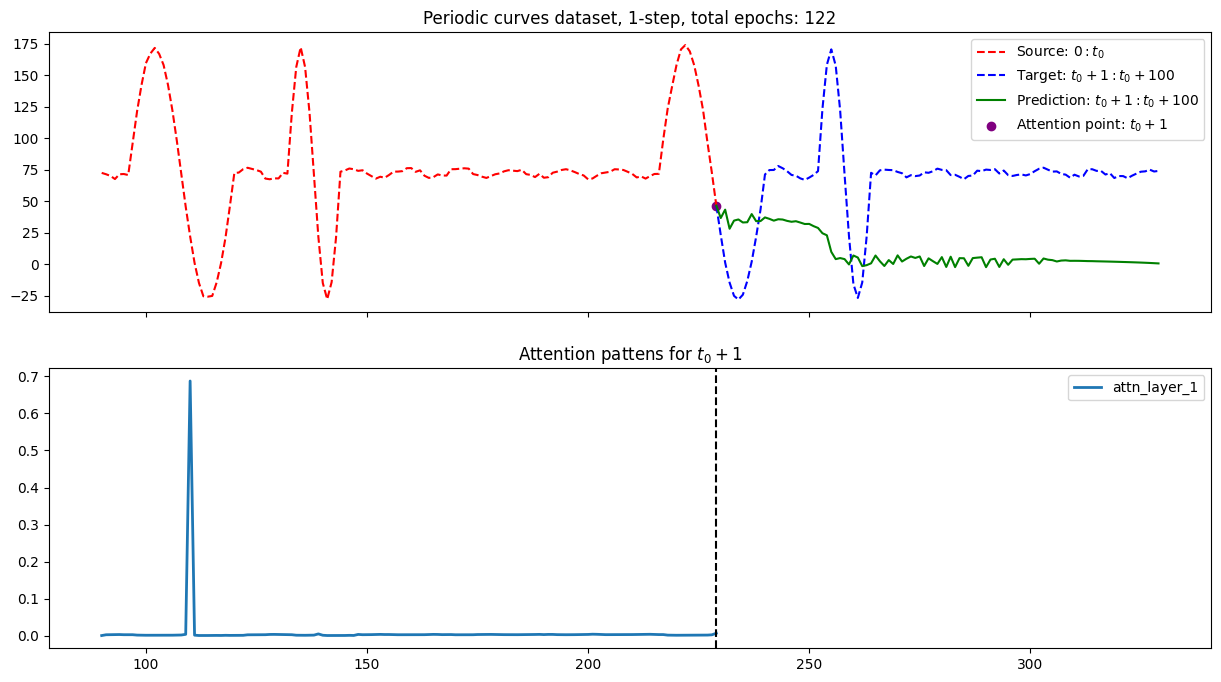

In [107]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

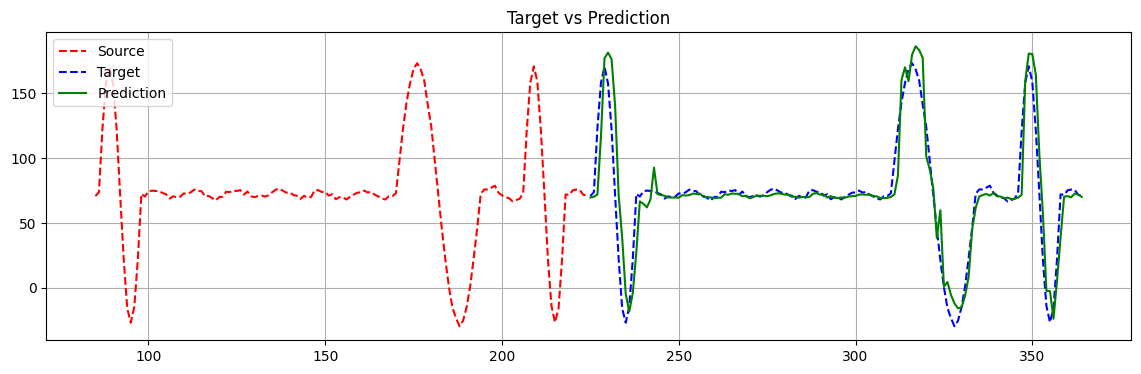

In [108]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 14: One-step and N-step prediction using *two heads* and the *infinity norm* distance function.

In [109]:
n_heads = 2                               # Number of heads used in multi headed simplex attention
distance_metric = infinity_norm                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [110]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2890.2319	val_loss=1469.3088	train_mape_loss=1.7749	val_mape_loss=2.2179	R_p=['0.2734', '0.2630']
epoch=1	train_loss=1486.0408	val_loss=1418.4030	train_mape_loss=2.0817	val_mape_loss=2.1503	R_p=['0.2779', '0.2705']
epoch=2	train_loss=1463.0816	val_loss=1386.5171	train_mape_loss=2.0575	val_mape_loss=2.1427	R_p=['0.2801', '0.2619']
epoch=3	train_loss=1415.4339	val_loss=1321.8203	train_mape_loss=2.0030	val_mape_loss=2.0982	R_p=['0.2860', '0.2506']
epoch=4	train_loss=1313.4034	val_loss=1155.9371	train_mape_loss=1.8802	val_mape_loss=1.8192	R_p=['0.3006', '0.2874']
epoch=5	train_loss=1130.4834	val_loss=942.3200	train_mape_loss=1.6116	val_mape_loss=1.4521	R_p=['0.2895', '0.2597']
epoch=6	train_loss=951.9371	val_loss=845.0756	train_mape_loss=1.2098	val_mape_loss=1.0818	R_p=['0.2803', '0.2446']
epoch=7	train_loss=864.2011	val_loss=777.9769	train_mape_loss=0.9952	val_mape_loss=0.8674	R_p=['0.2628', '0.2501']
epoch=8	train_loss=810.5292	val_loss=743.7865	train_mape_loss=0.8879	

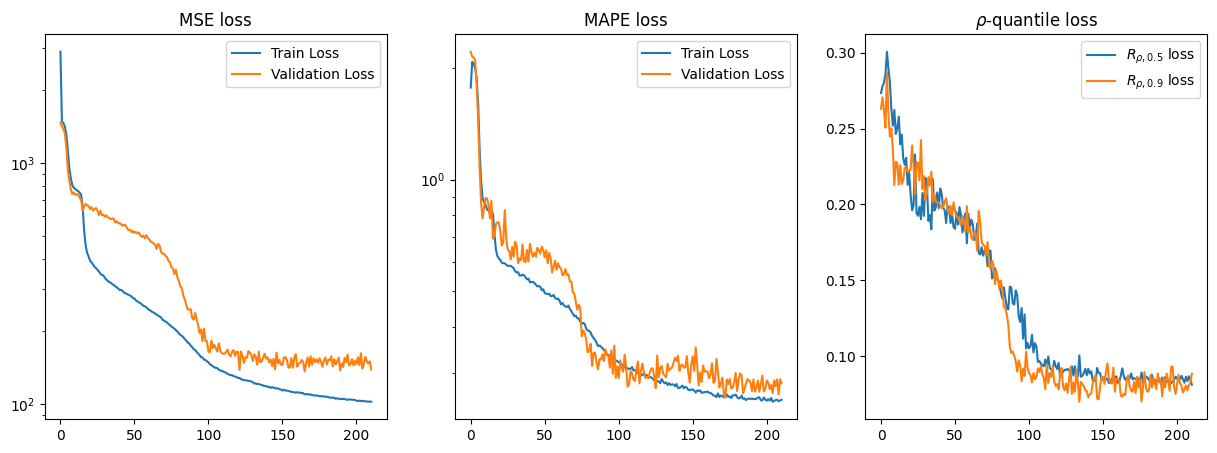

In [111]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [112]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(141.0150478515625,
 0.2743274691104889,
 [0.08244196325540543, 0.09228729456663132])

### N-step prediction

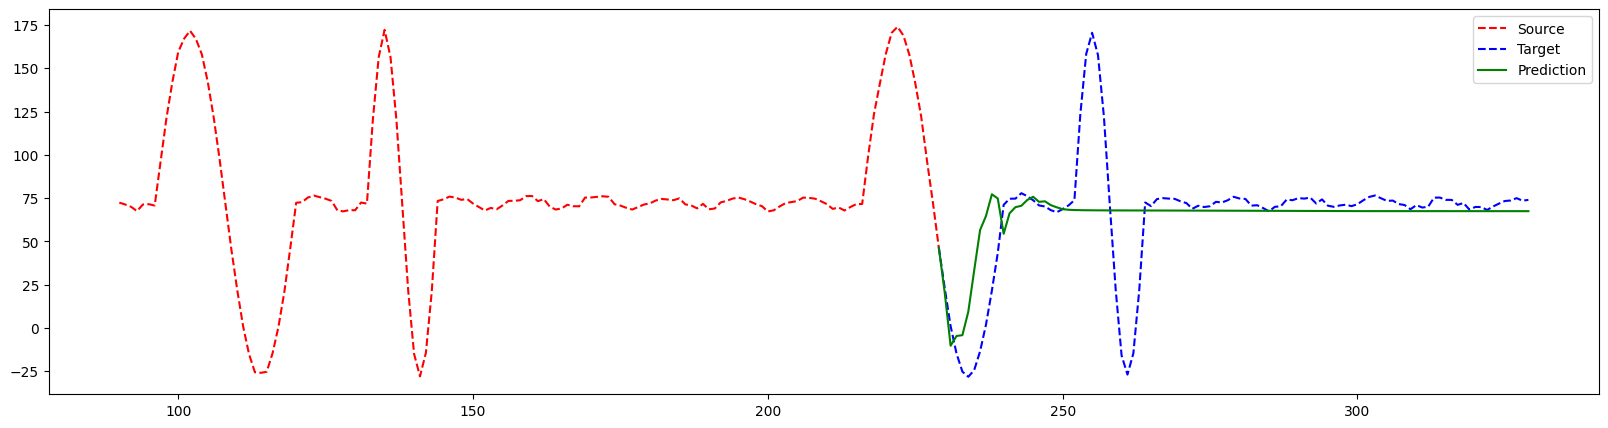

In [113]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

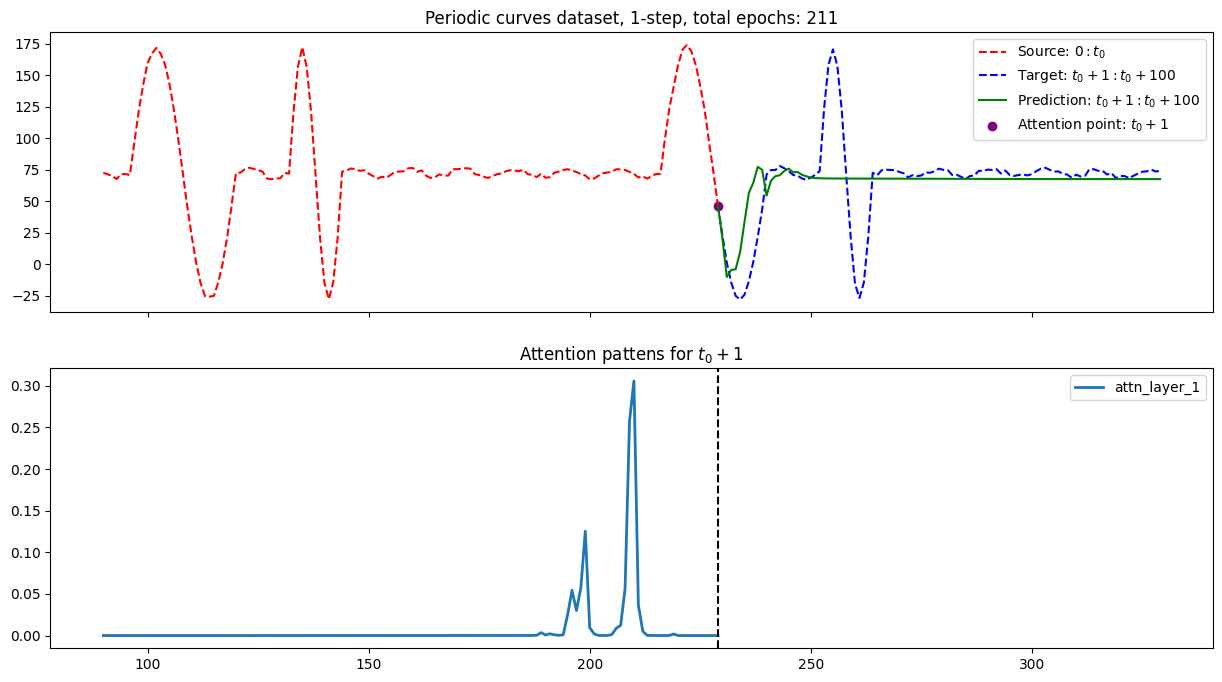

In [114]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

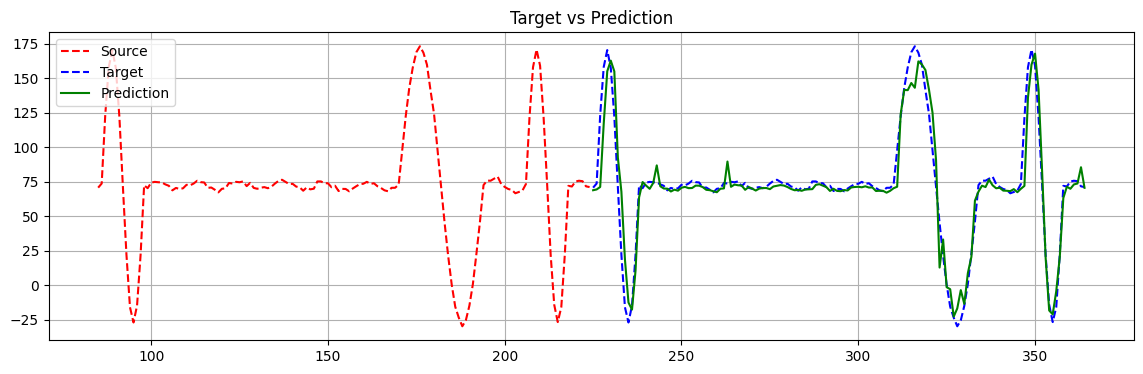

In [115]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 15: One-step and N-step prediction using *four heads* and the *infinity norm* distance function.

In [116]:
n_heads = 4                               # Number of heads used in multi headed simplex attention
distance_metric = infinity_norm                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [117]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2777.5403	val_loss=1457.5845	train_mape_loss=1.7814	val_mape_loss=2.2125	R_p=['0.2735', '0.2608']
epoch=1	train_loss=1482.1086	val_loss=1411.7605	train_mape_loss=2.0773	val_mape_loss=2.1591	R_p=['0.2780', '0.2646']
epoch=2	train_loss=1468.2137	val_loss=1391.4867	train_mape_loss=2.0601	val_mape_loss=2.1321	R_p=['0.2801', '0.2670']
epoch=3	train_loss=1433.8974	val_loss=1337.8162	train_mape_loss=2.0245	val_mape_loss=2.0640	R_p=['0.2847', '0.2752']
epoch=4	train_loss=1363.6799	val_loss=1239.4111	train_mape_loss=1.9414	val_mape_loss=1.9985	R_p=['0.2929', '0.2500']
epoch=5	train_loss=1237.4217	val_loss=1064.3530	train_mape_loss=1.7728	val_mape_loss=1.7442	R_p=['0.2981', '0.2526']
epoch=6	train_loss=1067.9580	val_loss=887.0706	train_mape_loss=1.4700	val_mape_loss=1.2974	R_p=['0.2874', '0.2742']
epoch=7	train_loss=924.3797	val_loss=840.2206	train_mape_loss=1.1646	val_mape_loss=1.2152	R_p=['0.2900', '0.2240']
epoch=8	train_loss=824.2660	val_loss=765.3580	train_mape_loss=0.991

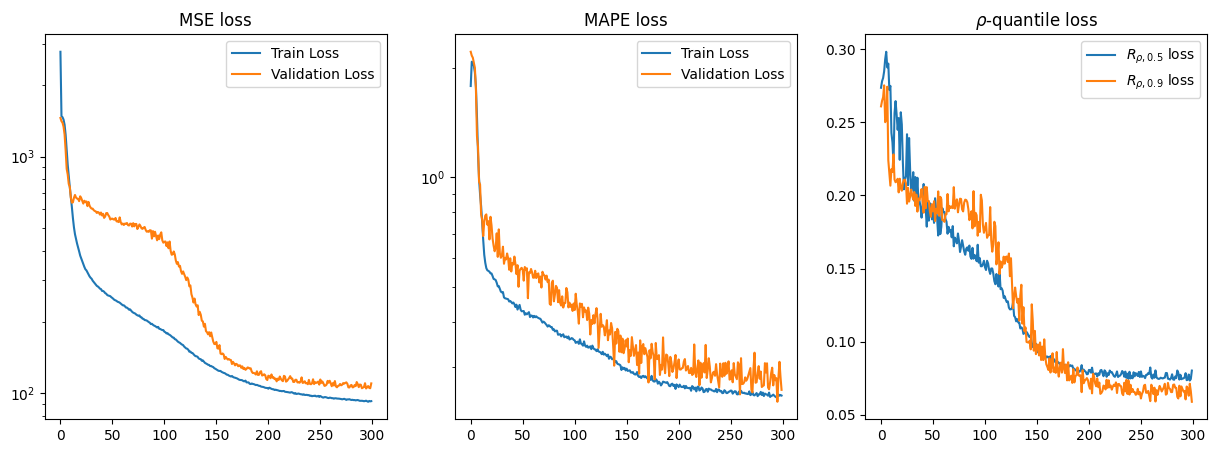

In [118]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [119]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(113.18190985107422,
 0.2562772786617279,
 [0.08401068300008774, 0.05631866306066513])

### N-step prediction

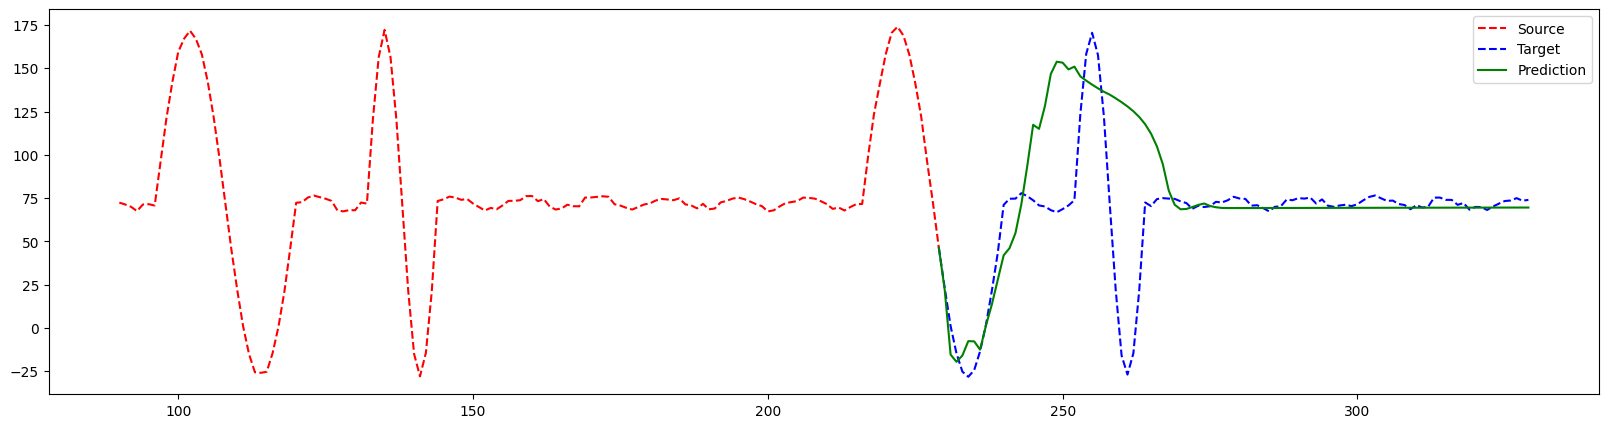

In [120]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

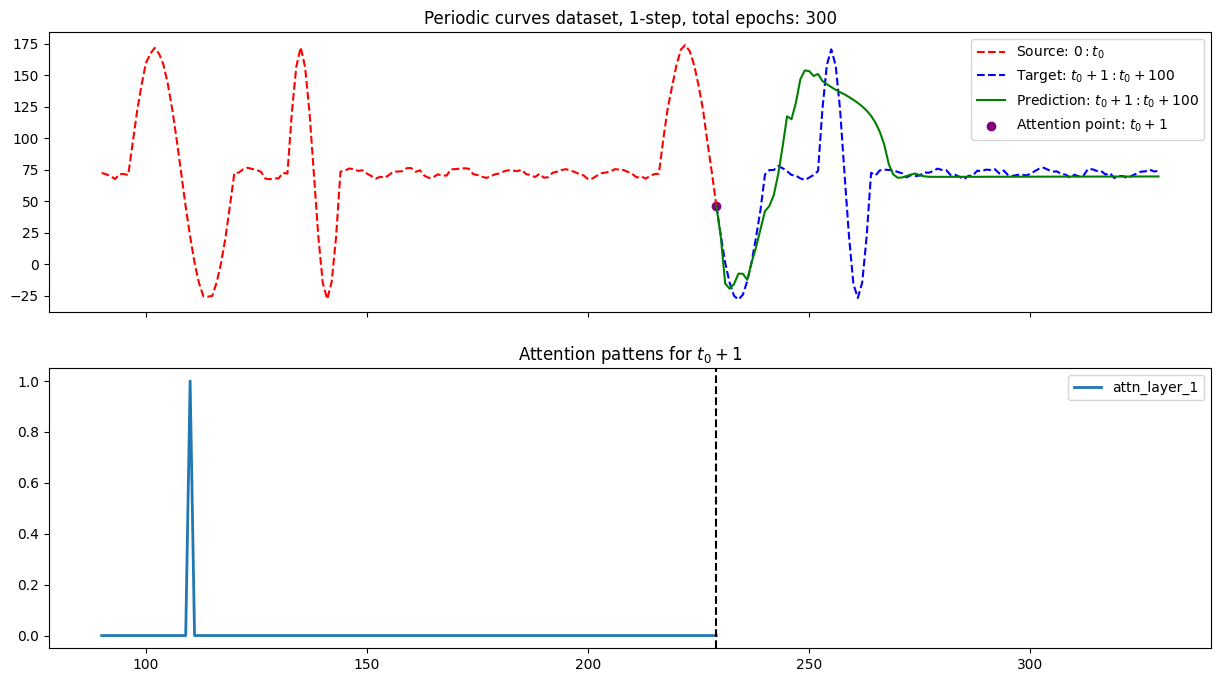

In [121]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

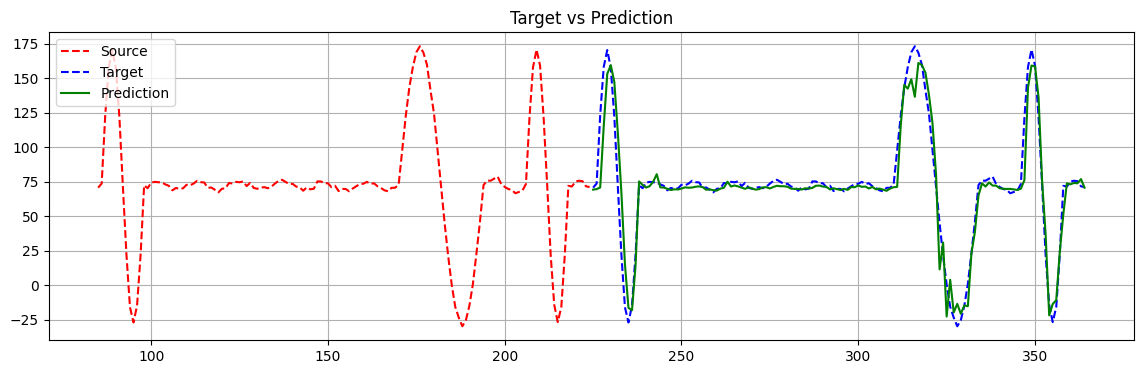

In [122]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 16: One-step and N-step prediction using *eight heads* and the *infinity norm* distance function.

In [123]:
n_heads = 8                               # Number of heads used in multi headed simplex attention
distance_metric = infinity_norm                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [124]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2879.3051	val_loss=1457.6701	train_mape_loss=1.7755	val_mape_loss=2.2161	R_p=['0.2734', '0.2595']
epoch=1	train_loss=1480.9088	val_loss=1395.7985	train_mape_loss=2.0775	val_mape_loss=2.1366	R_p=['0.2790', '0.2695']
epoch=2	train_loss=1466.3076	val_loss=1365.2076	train_mape_loss=2.0557	val_mape_loss=2.1059	R_p=['0.2796', '0.2676']
epoch=3	train_loss=1432.9426	val_loss=1287.8897	train_mape_loss=2.0211	val_mape_loss=2.0318	R_p=['0.2837', '0.2588']
epoch=4	train_loss=1327.0491	val_loss=1116.7584	train_mape_loss=1.8966	val_mape_loss=1.8042	R_p=['0.2938', '0.2540']
epoch=5	train_loss=1140.2690	val_loss=918.5241	train_mape_loss=1.6178	val_mape_loss=1.3565	R_p=['0.2925', '0.2723']
epoch=6	train_loss=972.2903	val_loss=847.5824	train_mape_loss=1.2633	val_mape_loss=1.2126	R_p=['0.2878', '0.2347']
epoch=7	train_loss=864.1084	val_loss=779.2283	train_mape_loss=1.0506	val_mape_loss=0.9397	R_p=['0.2758', '0.2193']
epoch=8	train_loss=788.3503	val_loss=751.2715	train_mape_loss=0.9290	

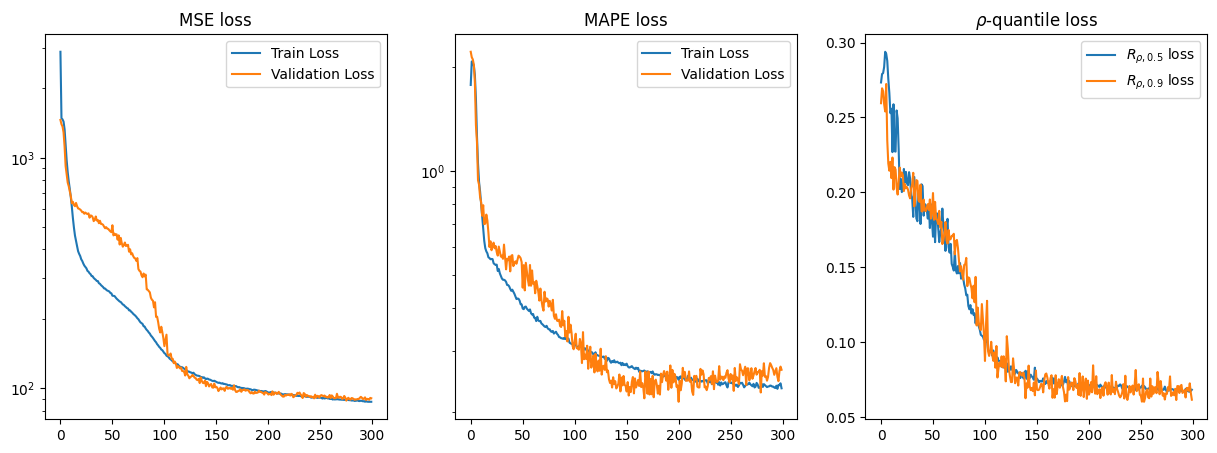

In [125]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [126]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(90.34508770751953,
 0.25857397890090944,
 [0.06883933395147324, 0.06261712312698364])

### N-step prediction

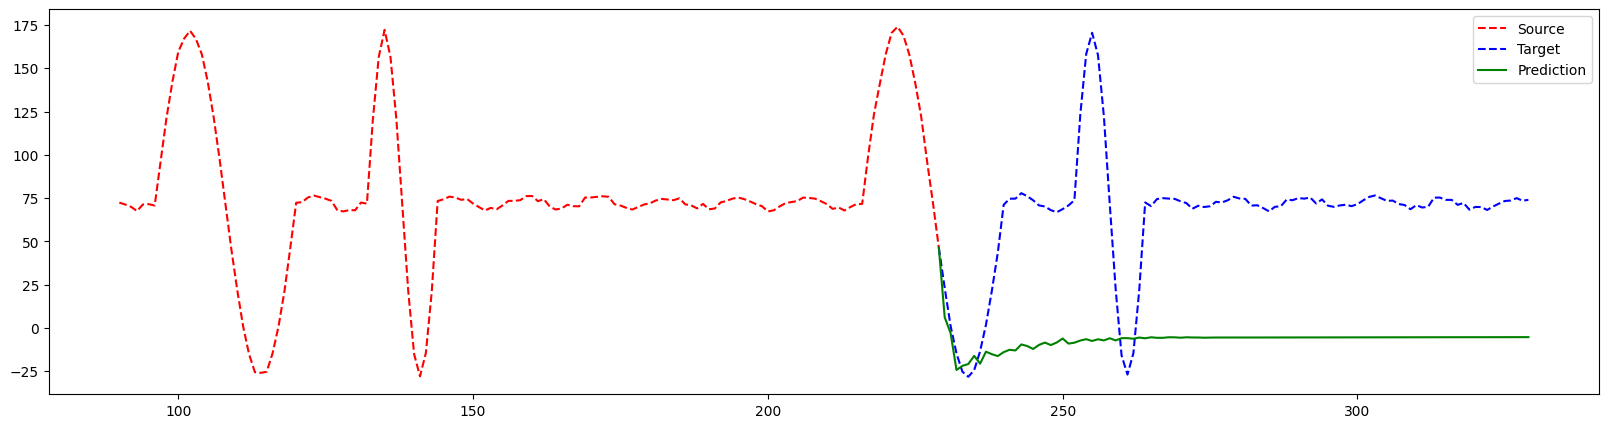

In [127]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

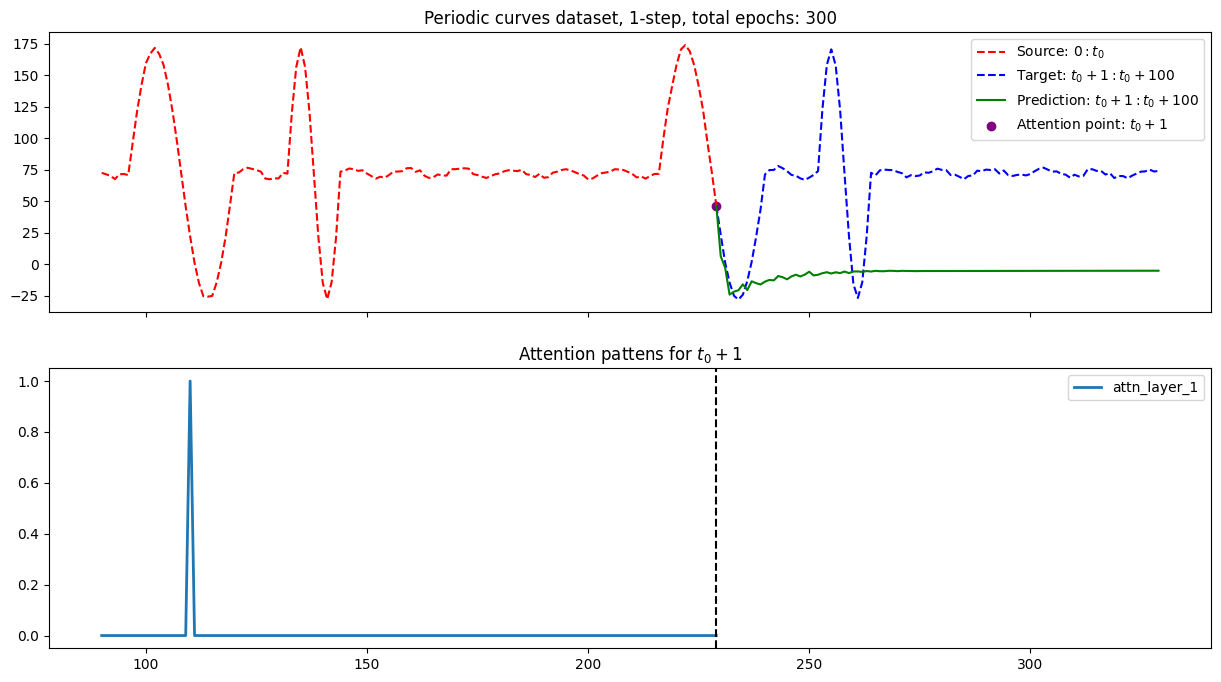

In [128]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

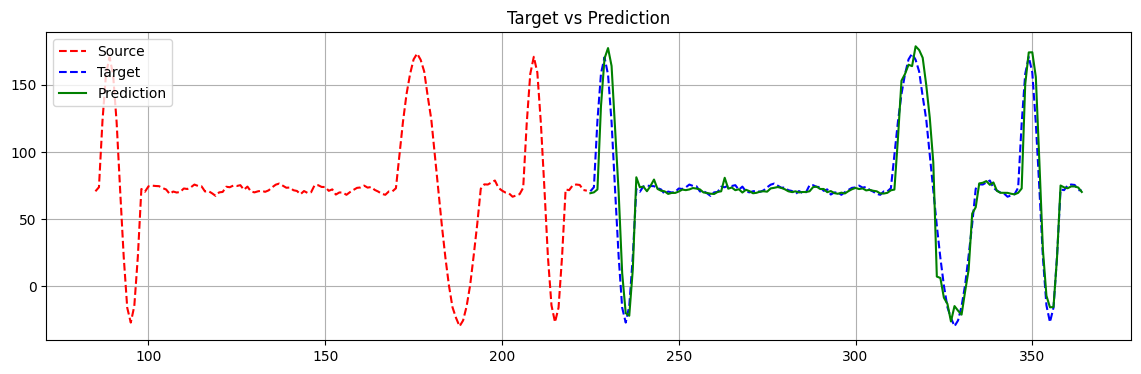

In [129]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()